---

## The following files are required for this project - they should all be in the zip

Jan2019.csv   
Feb2019.csv   
Mar2019.csv         
Apr2019.csv         
May2019.csv         
Jun2019.csv   
July2019.csv  
Aug2019.csv              
Sep2019.csv
Oct2018.csv        
Nov2018.csv         
Dec2018.csv               
negative-words.txt  
positive-words.txt
journeys.csv  
cyclingtrips_Sep2019.csv  
WomensApparelReviews.csv

## The can also be downloaded from this [Dropbox](https://www.dropbox.com/sh/ply2manmwzp774t/AAB7DCePDU-Q8DtZtBffBEKCa?dl=0)

# Task 1 - Analysing the product reviews

For this task we were asked to analyse product reviews and extract helpful information from them. We were provided with a dataset of reviews on womens clothing sold by a company online. In the file `WomensApparelReviews.csv` there are over 23000 reviews that are real but anonymized. The columns of this dataset are the following variables:

**Product ID**: integer variable that refers to the specific item that is reviewed.

**Age**: the reviewers age.

**Title**: the title picked by the reviewer (some reviewers didn't pick any titles).

**Review Text**: the body text of the review.

**Rating**: the product score given by the customer from 1 (worst), to 5 (best).

**Is it Recommended?**: the customers are asked whether or not they recommend the product. 1 means the product is recommended, 0 means not recommended.

**Department**: the products are classified in different departments such as dress, top and ...

A major part of this task is analysing the review text and deciding how positive or negative it is. To that end, there are two more data files: `positive-words.txt` and `negative-words.txt`, which contain lists of positive and negative words, respectively. These words come from the paper by *Minqing Hu and Bing Liu. "Mining and summarizing customer reviews." Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, Seattle, Washington, USA, Aug 22-25, 2004*. 

We were required to invent a metric for how positive or negative "Review Text" is, based on how many of its words are in the positive/negative word lists. For instance, is a review containing one positive and one negative word: overall positive, negative or neutral? The metric should be based on word occurence describing the positivity/negativity of the review. We chose to apply our metric to the "Title" also. 

After measuring positivity/negativity , we looked into what else we would compare about the dataset.  The following questions were suggested 

- What is the age distribution of customers?
- What is the most popular item in each age group? (choose and justify age ranges used)
- Using the measure of negativity or positivity that you define, rate the reviews.
- What is the average rating in positive, negative or neutral reviews?
- Is the rating correlated to your measure of negativity-positivity? 
- Are there many outliers who wrote a negative text but left a high rating (or vice versa)?
- Which product attracted the most positive reviews? This would help the company to focus more on the product that people liked or make changes to the product that people did not like. Is there any such advice you could give them on the products that could come from the reviews?
- What is the most recommended product? What is the least recommended product?
- Which group of reviewers wrote a longer text in their review? Do unhappy customers write longer reviews or satisfied customers? 
- Which age group uses more positive words? Which age group uses more negative words?
- Are older people more inclined to recommend a product or younger people?
- Is it true that unhappy customers use more capital letters? or it is the other way around?
- Can you come up with a way to consider the positive words in a negative statement negative? For example, "Not impressed or satisfied" is a negative title, but if you just count the positive and negative words, you will find two positive words ("impressed" and "satisfied") and a negative word ("not"). Hence, just based on the word count, you might wrongly find the title to be positive. This might be easier for the titles, but you can also break down the review text to sentences and apply your method there.


## Introduction Task 1

For this task we will first install a wordcloud package, then import all the libraries necessary for our analysis. Next we have a section where we import the data. The following section defines the functions necessary for our sentiment analysis and we apply these to our dataset.  We also add additional columns to our dataframe which we want to analyse later on. 

We will then commence the actual analysis of our data, first using our sentiment analysis and then some statistical analysis on the data more generally.

In [1]:
!pip install wordcloud #ensures wordcloud is installed

## Import libraries

In [2]:
import doctest
import numpy as np
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.ticker as ticker
from itertools import product
sns.set(style = 'darkgrid')

## Import data

We start by reading in the data files. We decided to convert the positive and negative word data into a list of the words within each category. We noticed that the positive and negative word lists had some extra text before the actual list commenced so we removed this first.

In [3]:
reviews = pd.read_csv('./WomensApparelReviews.csv', index_col = 0 )
reviews.head()
with open('./positive-words.txt', 'r') as f:
    pos_words = f.read().splitlines() 
    #Define regular expression to remove the first bit of the files
    reg = ".*;;', '', " # Anything before ;;','', 
    #Use sub method to Return the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string.
    pos_words = re.sub(reg, '', str(pos_words))
    pos_words = np.array(pos_words.replace("\'", '').split(', '))
with open('./negative-words.txt', 'r') as f:
    neg_words = f.read().splitlines() 
    neg_words = re.sub(reg, '', str(neg_words))
    neg_words = np.array(neg_words.replace("\'", '').split(', '))

We start by just having a quick look at the column names in our data frame:

In [4]:
reviews.columns

Index(['Product ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Is it Recommended?', 'Department'],
      dtype='object')

Next, we decided to have a look at the data types of the columns of reviews to ensure they were all as expected.

In [5]:
reviews.dtypes

Product ID             int64
Age                    int64
Title                 object
Review Text           object
Rating                 int64
Is it Recommended?     int64
Department            object
dtype: object

We can see that the Product ID is interpreted as a number but it is actually a unique identifier so it would make more sense for it to be an object. This ensures that, when we summarise information later on, we do not obtain values such as the mean of the Product ID as this is clearly nonsensical.

In [6]:
reviews = reviews.astype({'Product ID': 'object'})
reviews.dtypes

Product ID            object
Age                    int64
Title                 object
Review Text           object
Rating                 int64
Is it Recommended?     int64
Department            object
dtype: object

## Functions and expanding of data frame

The main thing we want to accomplish is having a measure of how positive the main review text and title text is based on how many positive and negative words were mentioned in them. To do this we have defined several functions that we can apply to the review text and title columns of the data frame.

First we define a function to find the index of where a word appears in an alphabetically sorted array (it will return 'False' if the word does not appear at all). We decided to use a binary function to do this as it is extremely inefficient to run through the entire positive/negative word list for every single word in every single review, so each time discarding of the first/last half depending of the list on where in the alphabet we are is much more efficient. We have tested the function for a word in both the positive and negative list and also added one that we expect to be false.

In [7]:
def binary_search(word, sorted_arr): 
    '''
    Fuction that uses binary search to find the existance of an element is a sorted array.
    Inputs:
        word: the element to find
        sorted_arr: sorted array to find the element in
    Return:
        mid: Index of the element in the array
        False: If element does not exist in the array
    
    Doctest: (two that should return an index and one that should return 'False')
    >>> print(binary_search('success', pos_words)) 
    1726
    >>> print(binary_search('failure', neg_words))
    1568
    >>> print(binary_search('failure', pos_words))
    False
    
    '''
    s = 0 #Initialises the start point of where in the array we are searching
    e = len(sorted_arr) - 1 #Initialises the end point of where in the array we are searching
    word = word.lower() #Ensures the word is all lower case as we assume the sorted array only contains lower cases
    while s <= e:
        mid = s + (e - s)// 2; 
        if sorted_arr[mid] == word: #If the word is in the middle of our array
            return mid 
        elif sorted_arr[mid] < word: #Else if the word is greater than the middle element of the array we are searching
                                     #in (indicating it is further down the alphabet)
            s = mid + 1 #Sets the new start point to be just past the middle of the array
        else: 
            e = mid - 1 #Sets the new end point to be just before the middle of the array
      
    #If we get to a point that the start index is greater than the end index the word is not in the array
    return False 

doctest.testmod() #Tests if the function above passes the doctests we wrote for it

TestResults(failed=0, attempted=3)

 Now we want to define a function that actually counts the amount of positive and negative words in a given text. We do this using our above function where we add 1 to a counter every time an index appears and do nothing if the above function returns 'False'. We tested this with a simple sentence, one that has punctuation to be removed first, and also ensured it gave '(0, 0)' when no positive or negative words appear.

In [8]:
def count_words(text):
    '''
    Function that returns a pair of numbers with the amount of positive and negative words in a given text
    Inputs:
        text: string for which the function will determine the amount of positive/negative words
    Return:
        (count_pos, count_neg): pair of numbers with the amount of positive and negative words in a given text
    
    Doctest: (one simple sentence, one with punctuation and one with no text to test those exceptions)
    >>> print(count_words('This project has been fun but difficult'))
    (1, 1)
    >>> print(count_words('Fun, fantastic, fabulous!'))
    (3, 0)
    >>> print(count_words('Very average sentence...'))
    (0, 0)
    '''
    if text is not np.nan: 
        text = re.sub(r'[^\w]', ' ', text) #Removes punctuation
        text = text.lower().split(' ') #Ensures the text is lower case and split wherever there is a space
        count_pos = 0 
        count_neg = 0
        for w in text:
            if binary_search(w, pos_words):
                count_pos += 1 #Adds 1 to count_pos as long as binary_search does not return 'False'
            elif binary_search(w, neg_words):
                count_neg += 1
        return (count_pos, count_neg)

doctest.testmod() 

TestResults(failed=0, attempted=6)

Next we want to use this information to classify a text as positive, negative, or neutral. This is quite a naive function and heavily influenced by what we believe is positive. We used a ratio between the amount positive and negative words to classify a text. If this ratio is at most 0.75 we classify a text as negative, if it is at least 1.5 we classify it as positive, otherwise we classify it as neutral.

For the test cases we have used tuples whose ratios define boundary points between the categories.

In [9]:
def sentiment_naive(counts):
    '''
    Function that classifies ratings into positive, neutral, negative based on the amount of positive and negative numbers
    Input: 
        counts: pair of numbers with the amount of positive and negative words in a given text
    Return:
        measure: the sentiment of the text
    
    Doctest: one on both boundaries, a nonzero neutral and (0,0)
    >>> print(sentiment_naive((3,4)))
    Negative
    >>> print(sentiment_naive((3,2)))
    Positive
    >>> print(sentiment_naive((5,6)))
    Neutral
    >>> print(sentiment_naive((0,0)))
    Neutral
    '''
    if counts:
        count_pos = counts[0] #Extracts the number of positive words from count
        count_neg = counts[1]
        if (count_pos == 0 and count_neg > 0) or (count_pos > 0 and count_neg > 0 and count_pos/count_neg <= 0.75):
            measure = 'Negative' #Sets the measure to negative if the ratio is at most 0.75
        elif (count_pos > 0 and count_neg == 0) or (count_pos > 0 and count_neg > 0 and count_pos/count_neg >= 1.5):
            measure = 'Positive' #Else sets the measure to positive if the ratio is at least 1.5
        else:
            measure = 'Neutral' #Else sets the measure to neutral
        return(measure)
    return None
doctest.testmod() 

TestResults(failed=0, attempted=10)

The last function we need to tidy our data is one that tells us which age category someone is in based on their age. We have decided on the following age categories: young (16 up until 35), adult (36 up until 45), middle-age (45 up until 65), retiree (66 up until 80), and old (81 onwards, or numerically up until 120).

In [10]:
def age_cat(age):
    '''
    Function that gives an age category when age is entered
    Input:
        age: the age we would like to categorise
    Output:
        k: the category it falls within
        
    Doctest: one in the middle of a category a boundary point
    >>> print(age_cat(56))
    Middle-age
    >>> print(age_cat(35))
    Young
    '''
    #Defines a dictionary with all our age categories
    age_dict = {'Young': [16,35], 'Adult': [36,45], 'Middle-age': [46, 65], 'Retiree': [66,80], 'Old': [81, 120]}
    for k, (l,u) in age_dict.items(): #loops ofver all age categories and corresponding lower and upper age
        if l <= age <= u: #If the age is between the lower and upper age
            return k #It returns the age category
doctest.testmod()

TestResults(failed=0, attempted=12)

We also want to add a function that, based on the above age category, returns the starting age of the category the individual is in as this makes it easy to naturally define the order in age categories for a heatmap later on.

In [11]:
def start_age(Age_Category):
    '''
    Function that gives an the starting age of an age category when the age category is entered
    Input:
        Age_Category: the Age Category we would like to find the minimum age of
    Output:
        The starting age
        
    Doctest: one in the middle of a category a boundary point
    >>> print(start_age('Young'))
    16
    >>> print(start_age('Adult'))
    36
    '''
    if Age_Category == 'Young':
        return(16)
    if Age_Category == 'Adult':
        return(36)
    if Age_Category == 'Middle-age':
        return(46)
    if Age_Category == 'Retiree':
        return(66)
    if Age_Category == 'Old':
        return(81)
doctest.testmod()

TestResults(failed=0, attempted=14)

Before we can apply these functions we need to check if there is missing data.

In [12]:
reviews.isna().sum() #Counts the amount of missing values in each column

Product ID               0
Age                      0
Title                 3810
Review Text            845
Rating                   0
Is it Recommended?       0
Department              14
dtype: int64

As we can see, not all reviews actually contain a review text and/or title. We should note here that, if that is the case, the texts would automatically be classified as neutral with counts (0,0). This is not accurate as someone may have left a rating of 5 but simply did not specify other information. 
We have decided to use complete case analysis, discarding entries in our data file where we do not have all data. This is a naive method of dealing with missing information however as we have a large sample size it will not have a significant impact to do this here. 
To ensure this we have quickly compared the basic stats on 'age', 'rating', and 'is it recommended?' for all reviews, discarding the entries with missing information.

In [13]:
reviews.describe().T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
Age,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Is it Recommended?,0.822362,0.382216,0.0,1.0,1.0,1.0,1.0


In [14]:
for c in ['Review Text', 'Title', 'Department']:
    reviews = reviews[reviews[c].notnull()] #Remove missing observations 
reviews.describe().T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
Age,43.260808,12.258122,18.0,34.0,41.0,52.0,99.0
Rating,4.183145,1.112224,1.0,4.0,5.0,5.0,5.0
Is it Recommended?,0.818177,0.385708,0.0,1.0,1.0,1.0,1.0


We can see that there are some changes to the mean and standard deviation but these are not significant.  A better way to deal with missing information could definitely be implemented by a more knowledgeable individual.

Now that we have our functions defined we can start adding information to the data frame, which we will need later on in our analysis. We add the length of the review as counted by the number of words (we can also instead count the number of characters but we found extremely similar results and decided that words are a more natural way to define length in a written text). 

Next, we will use the functions defined above and apply them to the title and review texts to get a column with the counts of positive and negative words as well as a column with our previously defined sentiment measure. 

We have also decided to add the sentiment of the rating as we have classified the review/title texts in to 'negative' 'neutral' 'positive' and want the rating to be easily comparable to our defined text sentiments. We decided that on a scale of 5 a rating below 3 is negative, a rating of 3 is neutral, and a rating of 4 and above is positive.

Finally, we have added a column which contains the age category for each of the reviews, and a column with the starting age of this age category.

In [15]:
#First splits the string into words and then finds the length
reviews['Review Length'] = reviews['Review Text'].str.split().apply(len)
reviews['Title Length'] = reviews['Title'].str.split().apply(len)

#Adds counts and sentiments for titles and review texts
reviews['Counts in Title'] = reviews['Title'].apply(count_words)
reviews['Counts in Review'] = reviews['Review Text'].apply(count_words)
reviews['Title Sentiment'] = reviews['Counts in Title'].apply(sentiment_naive)
reviews['Review Sentiment'] = reviews['Counts in Review'].apply(sentiment_naive)

#Adds sentiment for ratings
reviews['Rating Sentiment'] = 'Negative' #Sets all rating sentiments to negative
reviews.loc[reviews.Rating == 3,['Rating Sentiment']] = 'Neutral' #Changes those with rating 3 to neutral
reviews.loc[reviews.Rating >= 4,['Rating Sentiment']] = 'Positive' #changes those with rating >=4 to positive 

#Adds age categories
reviews['Age Category'] = reviews['Age'].apply(age_cat)

#Adds starting age of age categories
reviews['Starting Age of Age Category'] = reviews['Age Category'].apply(start_age)

In [16]:
reviews.sample(5) #Displays 5 random entries of our new data frame

,Product ID,Age,Title,Review Text,Rating,Is it Recommended?,Department,Review Length,Title Length,Counts in Title,Counts in Review,Title Sentiment,Review Sentiment,Rating Sentiment,Age Category,Starting Age of Age Category
15799,872,66,Comfortable arty,I loved this jacket the minute i saw it. satur...,5,1,Tops,90,2,"(1, 0)","(9, 0)",Positive,Positive,Positive,Retiree,66
14769,194,27,Well made,This jacket looks great and is well made. the ...,3,0,Intimate,26,2,"(1, 0)","(3, 0)",Positive,Positive,Neutral,Young,16
13771,1078,56,I'm over 50 and over 150 lbs and love this dress!,The large is perfect for me and is just my sty...,4,1,Dresses,86,11,"(1, 0)","(8, 1)",Positive,Positive,Positive,Middle-age,46
19486,895,32,Beautiful color,"The shirt fits very nicely, a little large but...",5,1,Tops,18,2,"(1, 0)","(2, 0)",Positive,Positive,Positive,Young,16
14309,677,53,If only it came in petite. . . .,I love this tunic. i am typically an xxs petit...,5,1,Intimate,99,9,"(0, 0)","(8, 2)",Neutral,Positive,Positive,Middle-age,46


From here on we have decided to focus on analysing the data with the sentiments we have defined, noting however that these are extremely naive. We have not taken into account negations, sarcasm, extreme misspellings, for example. Moreover we simply count all positive and negative words as the same, whereas some positive words are much more positive than others. Instead of having these binary counters we could have a scale from -5 to 5 where -5 is extremely negative, 0 is neutral, and 5 is extremely positive, this could also lead to a more accurate classification. A lot of work has already been done on this topic so all our further analysis could be repeated with something like NLTK which is a way of classifying texts into sentiments in a more accurate measure.

For now, we can at least have a look into cases where the Review Sentiment and Rating Sentiment clash and where the Title Sentiment and Rating Sentiment clash. We can also find out how often each of these occur.

In [17]:
#Prints the shape of the data frame which contains all reviews with clashing rating and review sentiment
print(reviews[reviews['Rating Sentiment'] != reviews['Review Sentiment']].shape)
#Display 5 random entries of it
reviews[reviews['Rating Sentiment'] != reviews['Review Sentiment']].sample(5)

(4967, 16)


,Product ID,Age,Title,Review Text,Rating,Is it Recommended?,Department,Review Length,Title Length,Counts in Title,Counts in Review,Title Sentiment,Review Sentiment,Rating Sentiment,Age Category,Starting Age of Age Category
20860,1075,47,Way too big,"This is such a great dress, i hate to return i...",3,0,Dresses,60,3,"(0, 0)","(5, 1)",Neutral,Positive,Neutral,Middle-age,46
1963,1083,31,An absolute hit - if you buy the right print,Dear creatures always has sizing issues. they ...,4,1,Dresses,91,10,"(1, 0)","(0, 4)",Positive,Negative,Positive,Young,16
3294,931,39,Adorable and easy to combine w/bottoms,I love this sweater. my only worry is that i'l...,4,1,Tops,43,6,"(2, 0)","(1, 2)",Positive,Negative,Positive,Adult,36
13616,1080,39,Unexpected delight,I wasn't expecting to love to this dress as mu...,5,1,Dresses,93,2,"(1, 1)","(4, 4)",Neutral,Neutral,Positive,Adult,36
9278,1080,30,Beautiful and timeless,This dress is gorgeous! pictures online do not...,5,1,Dresses,98,3,"(1, 0)","(2, 4)",Positive,Negative,Positive,Young,16


In [18]:
print(reviews[reviews['Rating Sentiment'] != reviews['Title Sentiment']].shape)
reviews[reviews['Rating Sentiment'] != reviews['Title Sentiment']].sample(5)

(6080, 16)


,Product ID,Age,Title,Review Text,Rating,Is it Recommended?,Department,Review Length,Title Length,Counts in Title,Counts in Review,Title Sentiment,Review Sentiment,Rating Sentiment,Age Category,Starting Age of Age Category
12975,1078,22,"Beautiful dress, just not for me","This dress is really gorgeous, really fun and ...",3,1,Dresses,82,6,"(1, 0)","(4, 2)",Positive,Positive,Neutral,Young,16
16141,1083,37,Bulky sleeves,This cute dress was very nice on. however my o...,3,1,Dresses,80,2,"(0, 1)","(5, 2)",Negative,Positive,Neutral,Adult,36
12061,872,25,One of my favorites!,This is one of the most flattering tops i've e...,5,1,Tops,92,4,"(0, 0)","(9, 1)",Neutral,Positive,Positive,Young,16
9773,1072,26,Not as pictured,"I bought this dress for a holiday party, and t...",2,0,Dresses,99,3,"(0, 0)","(5, 2)",Neutral,Positive,Negative,Young,16
20856,1022,43,These jeans rock!,These ultra-slimming jeans are so comfy. the r...,5,1,Bottoms,76,3,"(0, 0)","(5, 1)",Neutral,Positive,Positive,Adult,36


These number clearly are not good at all, a lot of review texts are falsely classified and even more titles are. The first reason for this is that our definition is extremely naive, however other things could have come into play. People might tend to leave more or less extreme reviews than they do ratings. And since the review text is so short (and the title generally even shorter) our function is even worse at finding accurate ratings, and often will classify something as neutral simply because no words from our positive or negative word list appear.

However we will now focus on analysis, and accept that our sentiments are not amazing.

## Analysis

### Sentiment Analysis

We will have a further look into how well our measures do by looking at the correlation between ratings, review sentiments, title sentiments, and whether an item is recommended. We have decided to display these using histograms, both one with overall counts and also one that has been normalised as this gives a better overview in general. We have decided to define functions to plot these as we will repeat this method repeatedly.

In [19]:
mycolours = ['tab:red', 'tab:green'] #Sets a colour palette with red and green (for recommended vs not recommended)

In [20]:
def normalise_bar(x, y, hue, data, ax=None, order= None, color = False):
    '''
    Function that plots a normalised bar plot 
    Input:
        x: The variable to plot on the x-axis
        y: How we want the data to be normalised
        hue: The variable to have in the legend
        data: The data frame our variables are stored in
        ax: When we have a subplot, which place the plot should appear in
        order: When our x variable has a natural order that is not low-high or alphabetical we can specify it here
        color: When our hue variable has a natural color asscociated we can specify it here
    Output:
        A normalised plot
    '''
    # Check if the palette is customised
    color_palette = None
    if color:
        color_palette = mycolours
    #Create a barplot using the parameters
    sns.barplot(x = x, y = y, hue = hue, ax = ax, order = order, palette = color_palette,
    data = (data[[x, hue]]
     .reset_index(drop = True)
     .groupby([x])[hue]
     .value_counts(normalize = True) #We use normalised argument to normalise the data in order to get percentage per group
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title('Percentage Frequency of {} by {}'.format(hue,x))
    plt.ylabel('Percentage %')

In [21]:
def plot_countplot(huevar, xvar, color, hue_order = None, order = None):
    '''
    Function that plots a bar plot and normalised version
    Input:
        huevar: The variable to have in the legend
        xvar: The variable to plot on the x-axis
        color: When our hue variable has a natural color asscociated we can specify it here
        hue_order: when our huevar has a natural order that is not low-high or alphabetical we can specigy it here
        order: When our x variable has a natural order that is not low-high or alphabetical we can specify it here
    Output:
        Two bar plots in one subaxis
    '''
    color_palette = None
    if color:
        color_palette = mycolours
    axis_order = None 
    if order:
        axis_order = order
    hue_order_ax = None 
    if order:
        hue_order_ax = hue_order
        
    f, axes = plt.subplots(1, 2, figsize=(12, 5)) #Sets a subplot
    #Plots the actual counts
    sns.countplot(x = xvar, hue = huevar, data = reviews, ax = axes[0], hue_order = hue_order_ax, order = axis_order, palette = color_palette)
    axes[0].set_title('Occurence of {}\nby {}'.format(xvar, huevar)) #Adds title to subplot
    axes[0].set_ylabel('Count') #adds y axis label
    
    #Use the previously defined function to plot the percentages
    normalise_bar(x = xvar, y = 'Percentage', hue = huevar, data = reviews, ax = axes[1], order = order, color = color)
    axes[1].set_title('Percentage Normalized Occurence of {}\nby {}'.format(xvar, huevar))
    axes[1].set_ylabel('% Percentage by {}'.format(huevar))
    plt.suptitle('Correlation Rating and Recommended')
    plt.subplots_adjust(top=0.8)
    plt.show()

We can now start comparing. First we have decided to show how many times a review has been recommended for each review sentiment.

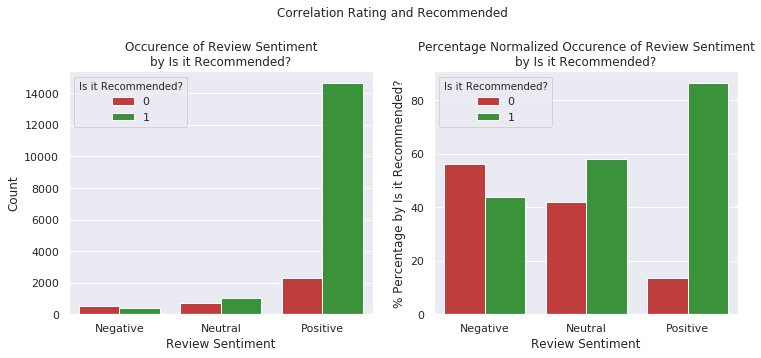

In [22]:
plot_countplot('Is it Recommended?', 'Review Sentiment', color = True, order = ['Negative', 'Neutral', 'Positive'])

We can see clearly in the normalised plot that there is a positive correlation between the review sentiment and whether a product is recommended. This makes sense, if a reviewer had a lot of positive things to say we expect the individual to recommend this product. An interesting point to note however, is that of the reviews we classified as negative, a significant percentage still recommend the product. If we consider the rating sentiment instead (as shown below), we can see that although the general idea is the same, it is much more extremely correlated which we expect. This again shows the shortcomings of our sentiment analysis.

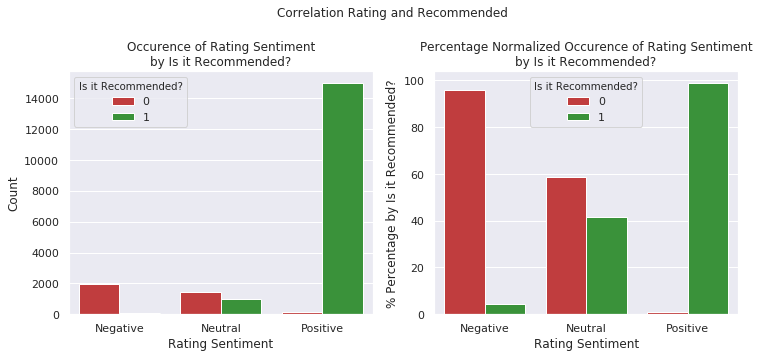

In [23]:
plot_countplot('Is it Recommended?', 'Rating Sentiment', color=True, order = ['Negative', 'Neutral', 'Positive'])

We can also look at how the title sentiment is correlated to whether a product is recommended. This gives a slightly more accurate representation than the review text sentiment, although still not perfect. This might be because titles are generally shorter so individuals will give their main impression whereas in the text they might try to give both the positives and negatives, making the text more likely to be classified as neutral.

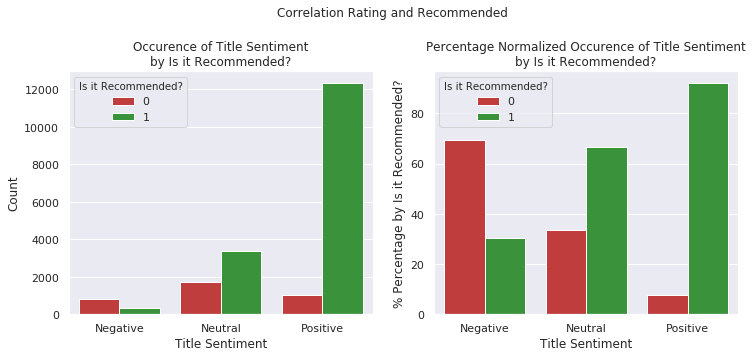

In [24]:
plot_countplot('Is it Recommended?', 'Title Sentiment', color= True, order = ['Negative', 'Neutral', 'Positive'])

We can also consider how our defined review text and title sentiments are related, as plotted below.

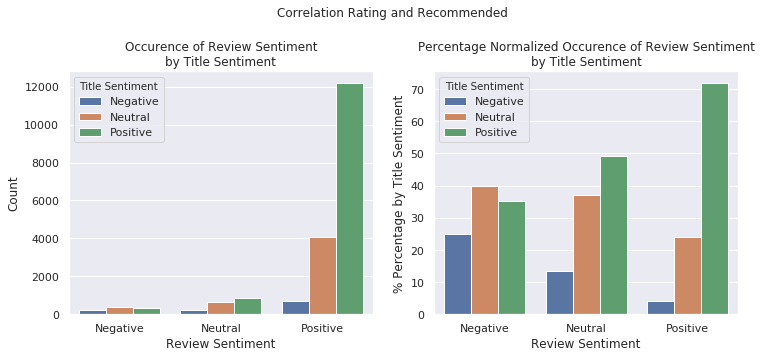

In [25]:
plot_countplot('Title Sentiment', 'Review Sentiment', color = False, hue_order = ['Negative', 'Neutral', 'Positive'], order = ['Negative', 'Neutral', 'Positive'])

Interestingly, although there is a positive correlation as expected, when we look at the reviews with negative review sentiments, there is a higher percentage of positive and neutral titles than there are negative titles. So although these customers used a lot of negative words in the review text they did not use many negative words in the title.

Finally, we will have a look at the average rating and recommendation level for each of the sentiments based on review text and sentiment.

In [26]:
#We first select the two relevant columns and then group by the review sentiment as we want the average rating for 
#negative neutral and positive, we then find the mean and finally sord them in descending order
reviews[['Rating', 'Review Sentiment']].groupby('Review Sentiment').mean().sort_values('Rating', ascending = False)

,Rating
Review Sentiment,
Positive,4.327592
Neutral,3.456657
Negative,2.945917


In [27]:
reviews[['Is it Recommended?', 'Review Sentiment']].groupby('Review Sentiment').mean().sort_values('Is it Recommended?', ascending = False)

,Is it Recommended?
Review Sentiment,
Positive,0.863985
Neutral,0.580737
Negative,0.439024


We can see that a positive review means a higher average rating and the product is more likely to be recommended. However the average rating for negative reviews would (using our definition of rating sentiment) appear to be neutral and that of the neutral reviews we would naturally have interpreted as positive. We can also plot a barplot to represent the amount of times each rating appears depending on the sentiment of the review text.

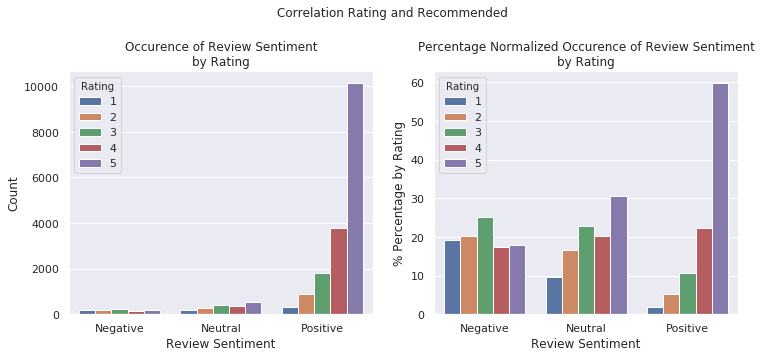

In [28]:
plot_countplot('Rating', 'Review Sentiment', color = False, order = ['Negative', 'Neutral', 'Positive'])

These show the same positive correlation, although again we seem to have the issue that of our negative reviews, quite a large percentage have positive or neutral ratings. 

We will repeat the same analysis for titles:

In [29]:
reviews[['Rating', 'Title Sentiment']].groupby('Title Sentiment').mean().sort_values('Rating', ascending = False)

,Rating
Title Sentiment,
Positive,4.500634
Neutral,3.696541
Negative,2.666667


In [30]:
reviews[['Is it Recommended?', 'Title Sentiment']].groupby('Title Sentiment').mean().sort_values('Is it Recommended?', ascending = False)

,Is it Recommended?
Title Sentiment,
Positive,0.921498
Neutral,0.664308
Negative,0.305200


For titles we again see that the order is correct, so positive titles have higher rating, and again we observe that the average ratings for positive and negative are more extreme, but both the rating and recommendation level for neutral titles would naturally be classified as neutral. We again can show a similar bar plot as for the review text but now for the titles.

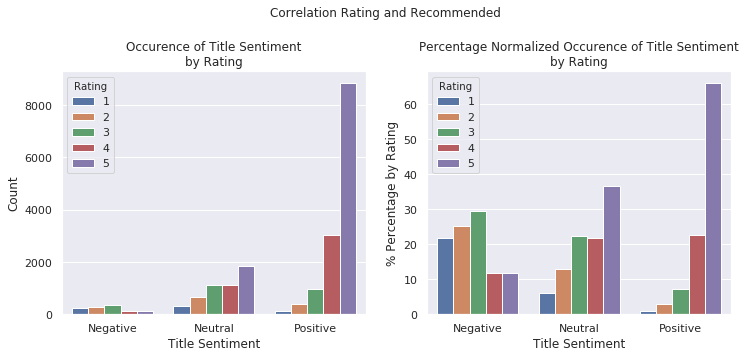

In [31]:
plot_countplot('Rating', 'Title Sentiment', color = False, order = ['Negative', 'Neutral', 'Positive'])

These plots again show the same positive correlation

From all of this we believe that, other than our naive classification, the main thing influencing these results is that people try to be nuanced with their reviews and titles. So as a result the ratings and recommendation levels are a better indication of whether a customer was satified with the product.

### Statistical Analysis

We will now commence our basic statistical analysis of the data. After just looking at some basic counts we will look at main differences between age groups. We will then look into differences between happy and unhappy customers (as classified by their recommendation/rating). After that we will look at some quick facts about departments. Finally, we will analyse the reviews of some extremely succesful and unsuccessful product and then make some improvement recommendations. 

#### Statistical Analysis - Basic counts 

Here we can see the amount of unique products and departments, which one is reviewed most, and how often this one is reviewed.

In [32]:
reviews[['Product ID', 'Department']].describe(include = ['O']).T.drop('count', axis = 1)

,unique,top,freq
Product ID,1095,1078,871
Department,6,Tops,8713


We can also plot an overview of the amount of times the 30 most reviewed products have been reviewed.

Text(0.5, 0, 'Count')

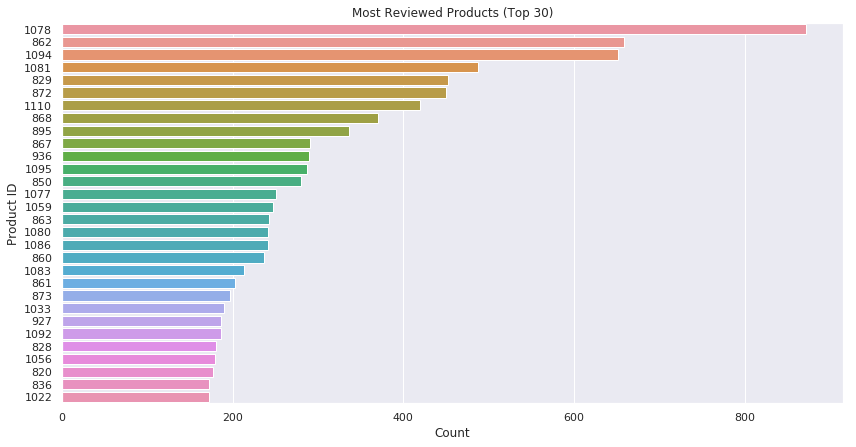

In [33]:
plt.subplots(figsize=[14,7])
#Counts how often each Product ID appears in the data, takes the first 30, and plots these in order
sns.countplot(y = 'Product ID', data = reviews[reviews['Product ID'].isin(reviews['Product ID'].value_counts()[:30].index)],
              order = reviews['Product ID'].value_counts()[:30].index)
plt.title('Most Reviewed Products (Top 30)')
plt.xlabel('Count')

It would be interesting for the company to see how this compares to the number of sales for each product as the reviews can provide reason for low sales.

Finally we decided to have a look at how often each department is reviewed, how many reviewers recommended the product, and how often each rating appeared. This again shows us that actually the majority of the customers were satisfied with their products.

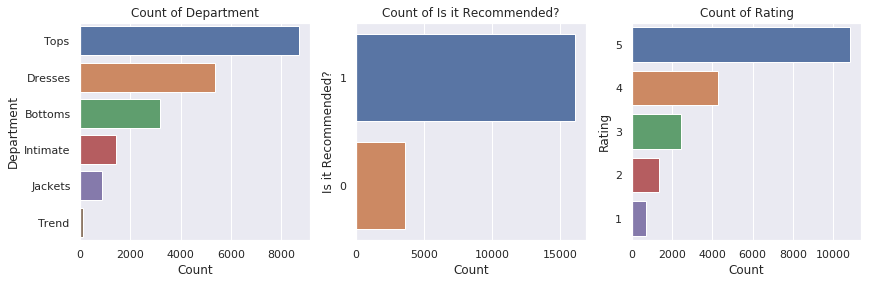

In [34]:
row_plots = ['Department', 'Is it Recommended?', 'Rating'] #Defines the three columns we want to count
f, axes = plt.subplots(1, len(row_plots), figsize = (14, 4), sharex = False) 

for i,x in enumerate(row_plots): #Loop for each of the columns of interest
    sns.countplot(y = x, data = reviews, order = reviews[x].value_counts().index, ax = axes[i]) #plots the counts
    axes[i].set_title('Count of {}'.format(x))
    axes[i].set_xlabel('')
    axes[i].set_xlabel('Count')
plt.show()

#### Statistical Analysis - Age Categories

To start the age analysis we first decided to plot a basic age distribution.

/home/kevin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


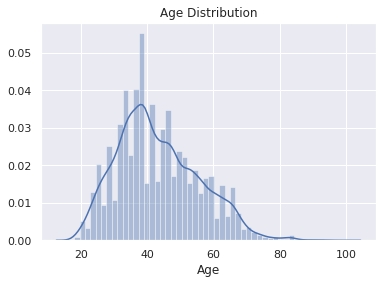

In [35]:
sns.distplot(reviews.Age).set_title('Age Distribution')
plt.show()

We can see that the amount of reviews initially increases with age with a peak around 40, then, as the customers get older, they leave less reviews again. 

Next, we decided to look into the length of the review left by customers in the different age categories. Intuitively we would expect younger people to leave shorter reviews.

In [36]:
#Select relevant columns, group by age category, take the mean and sort in descending order.
reviews[['Review Length', 'Age Category']].groupby('Age Category').mean().sort_values('Review Length', ascending = False)

,Review Length
Age Category,
Old,64.841463
Retiree,64.471239
Adult,62.348731
Middle-age,61.981726
Young,61.615318


Our intuition was indeed correct. The age groups with the longest reviews are old and retiree, adults are in the middle, and middle-aged and young people leave the shortest review. 

We can also test if the title length displays a similar trend.

In [37]:
reviews[['Title Length', 'Age Category']].groupby('Age Category').mean().sort_values('Title Length', ascending = False)

,Title Length
Age Category,
Young,3.382094
Middle-age,3.361313
Adult,3.320429
Retiree,3.184735
Old,2.987805


Interestingly, the trend is exactly opposite for the title length, however these are all so similar (small) that no real conclusions can be drawn.

Next, we will have a look at how many positive and negative words each age category uses. To do this we first add a column with the amount of positive words and then groupby and take the mean as previously. To find the number of positive words we simply look in the counts tuple for both the title and review text and add up the amount of positive words, and similarly for negative words.

In [38]:
reviews['Total Positive Words in Review'] = reviews['Counts in Review'].apply(lambda x: x[0]) + reviews['Counts in Title'].apply(lambda x: x[0])
pos = reviews[['Total Positive Words in Review', 'Age Category']].groupby('Age Category').mean()
pos.sort_values('Total Positive Words in Review', ascending = False)

,Total Positive Words in Review
Age Category,
Old,6.829268
Adult,5.562622
Retiree,5.547566
Middle-age,5.542713
Young,5.519752


In [39]:
reviews['Total Negative Words in Review'] = reviews['Counts in Review'].apply(lambda x: x[1]) + reviews['Counts in Title'].apply(lambda x: x[1])
neg = reviews[['Total Negative Words in Review', 'Age Category']].groupby('Age Category').mean()
neg.sort_values('Total Negative Words in Review', ascending = False)

,Total Negative Words in Review
Age Category,
Retiree,1.339602
Adult,1.313435
Young,1.303778
Middle-age,1.241866
Old,1.182927


We can see that people in the Old category use more positive words.  All other categories have extremely similar counts of total positive words used. They are also the category with the least Negative words used, which is interesting. To see if these numbers actually match their opinions of products, we can have a look at the average rating each age group has given.

In [40]:
reviews[['Rating', 'Age Category']].groupby('Age Category').mean().sort_values('Rating', ascending = False)

,Rating
Age Category,
Old,4.512195
Retiree,4.223451
Middle-age,4.214530
Adult,4.179733
Young,4.139382


As we can see it does indeed, whilst all other categories are quite close to another, the old age group has a significantly higher average. It is also interesting to note that the younger the reviewer, the lower their rating is. 

Next we decided to look at the percentage of recommended products in each age group.

In [41]:
reviews[['Is it Recommended?', 'Age Category']].groupby('Age Category').mean().sort_values('Is it Recommended?', ascending = False)

,Is it Recommended?
Age Category,
Old,0.890244
Retiree,0.846239
Middle-age,0.828852
Adult,0.817502
Young,0.801104


We can also plot this in a bar graph similar to the ones used in our sentiment analysis.

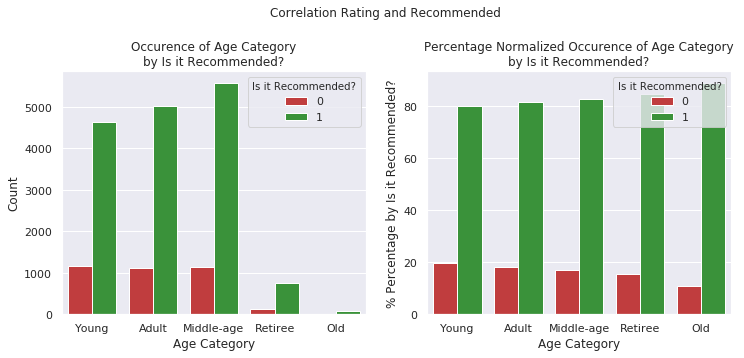

In [42]:
plot_countplot('Is it Recommended?', 'Age Category', color = True, order = ['Young', 'Adult', 'Middle-age', 'Retiree', 'Old'])

This is in accordance with the rating given.  Once again the oldest customers are happiest and indeed more likely to recommend a product. We also expect that in general a higher rating means customers are more likely to recommend a product.  
We next do a quick sanity check using a similar plot as above, as well as a correlation matrix.

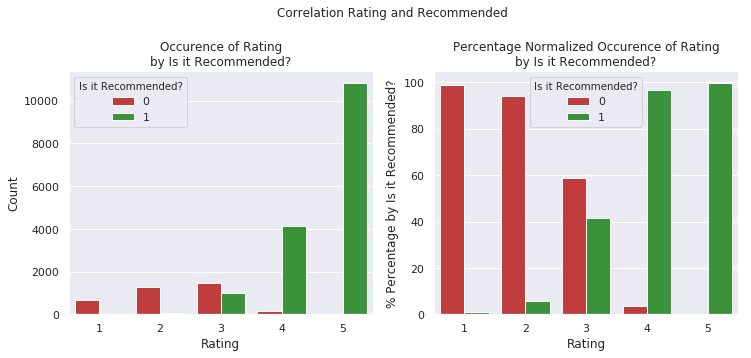

In [43]:
plot_countplot('Is it Recommended?', 'Rating', color = True)

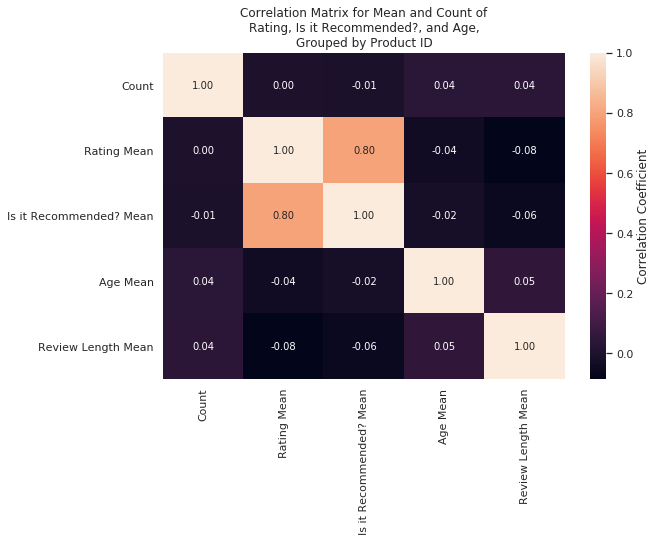

In [44]:
temp = (reviews.groupby('Product ID')[['Rating', 'Is it Recommended?', 'Age', 'Review Length']]
        .aggregate(['count', 'mean']))
temp.columns = ['Count', 'Rating Mean', 'Is it Recommended? Count',
                'Is it Recommended? Mean', 'Age Count', 'Age Mean', 'Review Length Count', 'Review Length Mean']
temp.drop(['Is it Recommended? Count', 'Age Count', 'Review Length Count'], axis = 1, inplace = True)

#Plot Correlation Matrix
f, ax = plt.subplots(figsize = [9, 6])
ax = sns.heatmap(temp.corr()
    , annot = True, fmt = '.2f', cbar_kws = {'label': 'Correlation Coefficient'})
ax.set_title('Correlation Matrix for Mean and Count of\nRating, Is it Recommended?, and Age,\nGrouped by Product ID')
plt.show()

We can see in these plots that in general, the higher the rating the more likely a product is to be recommended, which is exactly what we expect. Interestingly from the correlation matrix though, this is the only significant correlation, none of the other original information seems to be correlated.

The final thing we will look at for age category analysis is what the most popular product was in each age group. 

We could define popular as how many reviews have been posted about this product but instead we believe popular should mean that the customer enjoyed it and hence we decided to use whether a customer recommended the product as its measure for popularity. We have considered both the most popular items in terms of total count as well as with our positivity score which is the number of times an item was recommended divided by the total number of times it was reviewed.

In [45]:
reviews.groupby(['Age Category', 'Product ID']).size().reset_index(name = 'Total Number of Reviews').sort_values('Total Number of Reviews', ascending = False).groupby('Age Category').first()

,Product ID,Total Number of Reviews
Age Category,,
Adult,1078,291
Middle-age,1078,289
Old,1078,7
Retiree,862,33
Young,1078,258


As we saw in the top 30 most reviewed products, product 1078 also appears as the most reviewed product for 4 of the age categories.

In [46]:
pop = reviews.groupby(['Age Category', 'Product ID', 'Is it Recommended?']).size().unstack()
pop['Total'] = pop.iloc[:, 0] + pop.iloc[:, 1] #Adds the number of times it was not recommended and recommended
pop['Popularity Score'] = pop.iloc[:, 1] / pop.iloc[:, 2] #Number of times it was recommended divided by total
pop = pop.sort_values('Popularity Score', ascending = False)
for c in ['Young', 'Adult', 'Middle-age', 'Retiree', 'Old']: #For each of the age categories
    print(pop.groupby('Age Category').get_group(c).head(5)) #Get the relevant group and print the top 5

Is it Recommended?         0     1  Total  Popularity Score
Age Category Product ID                                    
Young        834         1.0  35.0   36.0          0.972222
             1100        1.0  21.0   22.0          0.954545
             939         1.0  17.0   18.0          0.944444
             1066        1.0  16.0   17.0          0.941176
             907         2.0  26.0   28.0          0.928571
Is it Recommended?         0     1  Total  Popularity Score
Age Category Product ID                                    
Adult        1008        2.0  43.0   45.0          0.955556
             903         1.0  19.0   20.0          0.950000
             1025        2.0  33.0   35.0          0.942857
             1030        2.0  27.0   29.0          0.931034
             1091        1.0  13.0   14.0          0.928571
Is it Recommended?         0     1  Total  Popularity Score
Age Category Product ID                                    
Middle-age   1060        1.0  29.0   30.

We can see that the most popular item for the young is 834, for adults it is 1008, for middle-age 1060, for retirees 872, and for old it is a tie between 1081, 868, 862. What is interesting is that, although most categories left most reviews for product 1078, it is in none of their top 5s. This would make us think that this product actually did not have great reviews.  We will quickly look at the average rating and number of recommendations for this product.

In [47]:
print(reviews[['Product ID', 'Rating']].groupby('Product ID').mean().loc[1078]) #We use loc to find product 1078
print(reviews[['Product ID', 'Is it Recommended?']].groupby('Product ID').mean().loc[1078])

Rating    4.177956
Name: 1078, dtype: float64
Is it Recommended?    0.811711
Name: 1078, dtype: float64


We can see that this product is quite well rated, just evidently not high enough to make the top 5 for any age categories.

#### Statistical Analysis - Happy vs Unhappy

The next thing we will look at is how reviews of happy customers compare to those of unhappy customers. Specifically we will have a look at the length of their reviews and how many capital letters they use. 
We could also have shown both of these for titles, however we arrived at similar conclusions so decided to take these out of our final submission.

First, we have looked at the average review text length depending on whether a product is recommended of not and what its rating is.

print(reviews[['Review Length','Is it Recommended?']].groupby('Is it Recommended?').mean())
print(reviews[['Review Length','Rating']].groupby('Rating').mean())

We can see that those who do not recommend a product use slightly more words. Interestingly from the comparisons using rating, those with neutral ratings leave longer reviews. We can also do this with the rating sentiment:

In [48]:
print(reviews[['Review Length', 'Rating Sentiment']].groupby('Rating Sentiment').mean())

                  Review Length
Rating Sentiment               
Negative              62.638713
Neutral               66.062500
Positive              61.401730


This now clearly show that neutral reviewers leave significantly longer reviews than positive/negative ones. So customers that are neither happy nor unhappy actually leave the longer reviews.

Next we will look at the use of capitals, we first define a function which counts the number of capitals in a text.

In [49]:
def count_capitals(text):
    '''
    Function counting the number of capitals in a text
    Input:
        text: the text we wish to analyse
    Output:
        the number of capitals in this test
    
    Doctest
    >>> print(count_capitals('i am not a great writer and do not use capitals'))
    0
    >>> print(count_capitals('I AM SCREAMING BECAUSE I HAVE AN OPINION'))
    33
    '''
    text = str(text) 
    return sum(1 for c in text if c.isupper())
doctest.testmod() 

TestResults(failed=0, attempted=16)

We can now add a column in our data frame to store this information and look at the mean number of capitals per rating and recommendation level.

In [50]:
reviews['Amount of Capitals in Review'] = reviews['Review Text'].apply(count_capitals)

print(reviews[['Amount of Capitals in Review', 'Rating']].groupby('Rating').mean())
print(reviews[['Amount of Capitals in Review', 'Is it Recommended?']].groupby('Is it Recommended?').mean())

        Amount of Capitals in Review
Rating                              
1                           0.995658
2                           0.997059
3                           0.997565
4                           0.996270
5                           1.000460
                    Amount of Capitals in Review
Is it Recommended?                              
0                                       0.997203
1                                       0.999130


These are all pretty much 1 which is quite unexpected. We will have a look at the overview of how many times we encounter each amount of capitals per rating and recommendation:

In [51]:
reviews.groupby(['Rating', 'Amount of Capitals in Review']).size().unstack(level = 1, fill_value = 0)

Amount of Capitals in Review,0,1,2,3,13
Rating,,,,,
1,4,686,1,0,0
2,4,1356,0,0,0
3,12,2447,4,1,0
4,23,4260,5,1,0
5,24,10817,15,1,1


In [52]:
reviews.groupby(['Is it Recommended?', 'Amount of Capitals in Review']).size().unstack(level = 1, fill_value = 0)

Amount of Capitals in Review,0,1,2,3,13
Is it Recommended?,,,,,
0,16,3554,4,1,0
1,51,16012,21,2,1


What stands out it that there exists 1 review which is recommended and has rating 5 that has 13 capital letters in it, all others have at most 3 (and for the majority have only 1), based on this we can hence conclude there is no difference between unhappy and happy customers when it comes to use of capitals.

Out of interest, we decided to look up the review with 13 capitals, here it is:

In [53]:
pd.set_option('display.max_colwidth', -1)
reviews.sort_values('Amount of Capitals in Review', ascending = False).head(1).iloc[:, 3]

15432    I love this dress! the colors work well with my olive skin color, it has pockets and it has a hi-lo front/back.Ì¢åÊÌ¢åÊi have slim hips so the tie waist is very flattering which gives an hourglass figure.Ì¢åÊÌ¢åÊi am 5?2?, 116 lbs and a 32d.Ì¢åÊÌ¢åÊi usually need a petite size because retailer dresses run a little long on me. but i was able to get away with getting an xs regular because of the hi-lo length. it fell perfectly above my knee.
Name: Review Text, dtype: object

We note that, other than the capital at the start of the sentence, all capitals actually appear to be style issues - maybe the reviewer used symbols/swearwords that have been automatically replaced by these  interesting letters, or maybe their cat simply walked over their keyboard.

We will quickly also look at a few other reviews to get a better understanding of why most of them only use 1 capital letter.

In [54]:
pd.set_option('display.max_colwidth', -1)
reviews.head(5).iloc[:, 3]

2    I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c
3    I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!                                                                                                                                                                                                                                                                                                                                                                             

An interesting thing to note is that they all start with a capital but have no other capitals later on, even 'i', which generally would be capitalised is lower case unless at the start. We think this might have to do with the system that collects the reviews. Most people are used to software automatically changing a lower case i to and upper case I if the letter is on its own, so they would not go through the effort of making it upper case. 
So we believe the system that collects this data automatically capitalises the first letter and nothing else, so unless reviewers went through the effort of changing it, they will all have exactly 1 capital.

#### Statistical Analysis - Departments

Now we will have a quick look at departments. 
We decided to use a heatmap to display the percentage of times each rating occurs for each category and the percentage of reviews from each age group are about each category. 
As we saw previously, some categories are much more reviewed than others, which is why we looked at percentages.

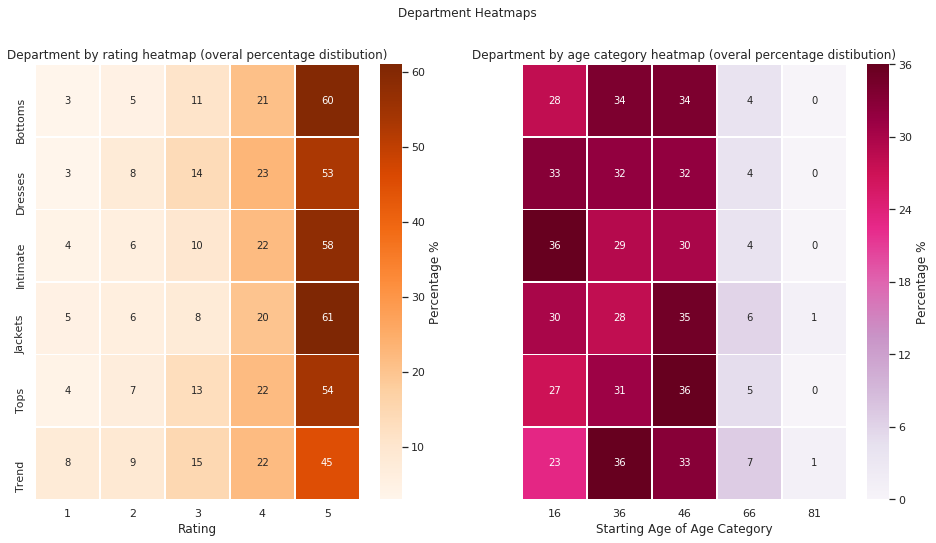

In [55]:
f, ax = plt.subplots(1, 2, figsize = (16, 8), sharey = True)

#Plots heatmap of percentage of ratings per department, we normalize and specify mul(100) to ensure percentages
#we have also indicated that we roung to 0 digits, and use oranges for our colour
sns.heatmap(pd.crosstab(reviews['Department'], reviews['Rating'], normalize = 'index').mul(100).round(0),
            annot = True, linewidths = .5, ax = ax[0], fmt = 'g', cmap = 'Oranges',
                cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Department by rating heatmap (overal percentage distibution)')
ax[0].set_ylabel('')

#this time we use purple-red (PuRe) for colour and look at the starting age of category instead of rating
sns.heatmap(pd.crosstab(reviews['Department'], reviews['Starting Age of Age Category'], normalize = 'index').mul(100).round(0),
            annot = True, linewidths = .5, ax = ax[1], fmt = 'g', cmap = 'PuRd', 
                cbar_kws = {'label': 'Percentage %'})
ax[1].set_title('Department by age category heatmap (overal percentage distibution)')
ax[1].set_ylabel('')

plt.suptitle('Department Heatmaps')
plt.show()

We can see that jackets get the largest percentage of 5 ratings and trend the lowest.  
Trend also gets the highest percentage of low ratings. This is not a good indicator. 
A recommendation to the company would hence be to review their trend department.  These should give very good reviews and should reflect items that people currently want. 

When it comes to ages we can see that in most categories the older customers provide significantly less reviews in general, and that for 81+ the only categories where at least a (rounded) percent is made up by them are bottoms and intimates. 
It is also interesting to note that the young category makes up a lower percentage of trend reviews compared to the adults and middle-aged customers which is perhaps suprising.

#### Statistical Analysis - Extremely Successful/Unsuccessful products

Now we will look at some of the most successful and unsuccessful products. To do so we will look at the products with the highest and lowest average recommendation scores and ratings.

In [56]:
Most_Rec = reviews.groupby(['Product ID', 'Is it Recommended?']).size().unstack() #counts how often each rating occurs
#Defines popularity score as recommended / total
Most_Rec['Popularity Score'] = Most_Rec.iloc[:, 1] / (Most_Rec.iloc[:, 0] + Most_Rec.iloc[:, 1])
Most_Rec.sort_values('Popularity Score', ascending = False).head(5) #Gives top 5

Is it Recommended?,0,1,Popularity Score
Product ID,,,
1024,1.0,27.0,0.964286
960,1.0,22.0,0.956522
964,3.0,62.0,0.953846
839,2.0,41.0,0.953488
967,1.0,19.0,0.950000


In [57]:
Most_Rec.sort_values('Popularity Score', ascending = True).head(5) #Gives bottom 5

Is it Recommended?,0,1,Popularity Score
Product ID,,,
1006,4.0,1.0,0.200000
183,3.0,1.0,0.250000
569,3.0,1.0,0.250000
453,3.0,1.0,0.250000
946,5.0,2.0,0.285714


These are the top and bottom fives when it comes to what percentage of reviewers recommended the product. We can see that 1024 is the most recommended and 1006 the least.

Similarly we can find the top and bottom five when we look at rating. Here we have defined most popular as highest amount of 4 and 5 ratings and least popular as highest amount of 1 and 2 ratings.

In [58]:
Most_Pop = reviews.groupby(['Product ID', 'Rating']).size().unstack()
#Popularity Score (number of rating 3 or 4 / total)
Most_Pop['Popularity Score'] = (Most_Pop.iloc[:, 3] + Most_Pop.iloc[:, 4]) / (Most_Pop.iloc[:, 0] + Most_Pop.iloc[:, 1] + Most_Pop.iloc[:, 2] + Most_Pop.iloc[:, 3] + Most_Pop.iloc[:, 4])
Most_Pop = Most_Pop.sort_values('Popularity Score', ascending = False)
Most_Pop.head(5)

Rating,1,2,3,4,5,Popularity Score
Product ID,,,,,,
834,1.0,6.0,7.0,24.0,87.0,0.888000
939,1.0,1.0,7.0,12.0,51.0,0.875000
1022,6.0,8.0,10.0,27.0,121.0,0.860465
1066,2.0,4.0,5.0,13.0,54.0,0.858974
1008,6.0,2.0,15.0,30.0,110.0,0.858896


In [59]:
Least_Pop = reviews.groupby(['Product ID', 'Rating']).size().unstack()
#Popularity Score (number of rating 1 or 2 / total)
Least_Pop['Popularity Score'] = (Least_Pop.iloc[:, 0] + Least_Pop.iloc[:, 1]) / (Least_Pop.iloc[:, 0] + Least_Pop.iloc[:, 1] + Least_Pop.iloc[:, 2] + Least_Pop.iloc[:, 3] + Least_Pop.iloc[:, 4])
Least_Pop = Least_Pop.sort_values('Popularity Score', ascending = False)
Least_Pop.head(5)

Rating,1,2,3,4,5,Popularity Score
Product ID,,,,,,
1039,2.0,2.0,1.0,1.0,1.0,0.571429
455,1.0,1.0,1.0,1.0,1.0,0.400000
884,1.0,3.0,1.0,4.0,1.0,0.400000
1016,3.0,5.0,3.0,7.0,6.0,0.333333
1145,2.0,1.0,2.0,1.0,3.0,0.333333


We can see here that with this definition of popularity we have 834 as the most popular item and 1039 as the most negative. 
Interestingly, although not unsurprisingly, we have completely different top and bottow 5s. This is due to the fact that the second definition does not know how to handle reviews with Rating 3. We generally expect that most people who rate a product 1 or 2 will not recommend it and those who review it 4 or 5 will, however for 3 we do not know. Let us see the actual statistics below.

In [60]:
reviews.groupby(['Rating', 'Is it Recommended?']).size()

Rating  Is it Recommended?
1       0                     684  
        1                     7    
2       0                     1280 
        1                     80   
3       0                     1444 
        1                     1020 
4       0                     146  
        1                     4143 
5       0                     21   
        1                     10837
dtype: int64

We can see that indeed that products with ratings 1 and 2 generally will not be recommended and when ratings are 4 or 5 the individual will typically recommend the product. For 3 the split is that approximately 3/5 of the people will not recommend it and 2/5 will. For this reason we think the recommendation popularity definition is more accurate and we will use this to create some wordclouds that can help us advice the company.

#### Statistical Analysis - Advice

We will now display two wordclouds, one for positive words used in the recommended reviews and one for negative words used in the not recommended reviews. We will first define functions to create these.

In [61]:
stopwords = set(STOPWORDS)
size = (10, 7)

def plot_wordcloud(text, title, stopwords = stopwords, size = size):
    '''
    Function to plot wordcloud
    Input:
        text: text to plot in wordcloud
        title: main header of wordcloud
        stopwords: words that should be skipped
        size: size of figure
    Output:
        a wordcloud
    '''
    
    # Setting figure parameters
    matplot.rcParams['figure.figsize'] = (10.0, 10.0)
    matplot.rcParams['font.size'] = 12
    matplot.rcParams['savefig.dpi'] = 100
    matplot.rcParams['figure.subplot.bottom'] = .1 
    
    # Processing Text
    wordcloud = WordCloud(width = 1600, height = 700, background_color = 'aliceblue', stopwords = stopwords).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize = size, dpi = 80, facecolor = 'aliceblue', edgecolor = 'lightgoldenrodyellow')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(title, fontsize = 50, color = 'mediumaquamarine')
    plt.tight_layout(pad = 0)
    plt.show()

In [62]:
def pos_or_neg(lst, keep_positive = True):
    '''
    Function that ensures we only plot a wordcloud of positive or negative words
    Input:
        lst: the list of words
        keep_positive: boolean to indicate if we are looking at positive or negative words 
    Output:
        filtered_words
    '''
    filtered_words = []
    for text in lst:
        if text is not np.nan:
            text = re.sub(r'[^\w]', ' ', text) #Removes punctuation
            text = text.lower().split(' ') #Splits into words
            for w in text:
                if keep_positive: #If we consider positive words
                    if binary_search(w, pos_words): #Use our previously definded function to find an index for each word
                        filtered_words.append(w) #and add this to the filtered_words if the index is not False
                else:
                    if binary_search(w, neg_words):
                        filtered_words.append(w)
    filtered_words = ' '.join(filtered_words)
    return filtered_words

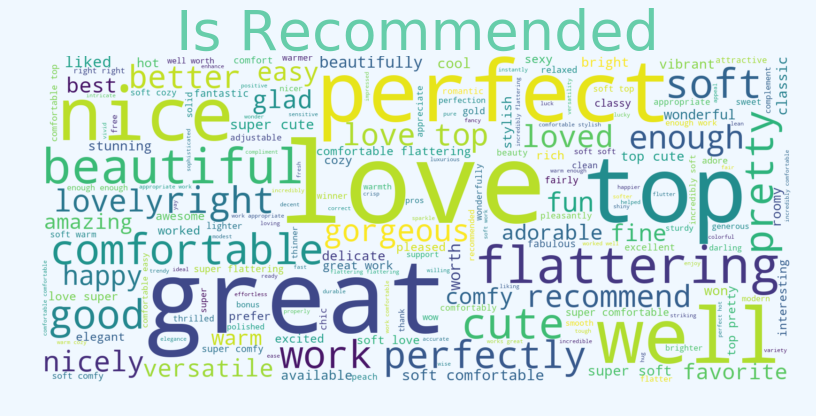

In [63]:
title ='Is Recommended'
temp = reviews['Review Text'][reviews['Is it Recommended?'] == 1] #All positive recommendations

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(reviews['Department'][reviews['Department'].notnull()].unique())])

filtered_list = pos_or_neg(list(temp), keep_positive = True)
plot_wordcloud(text = filtered_list, title = title, stopwords = new_stop)

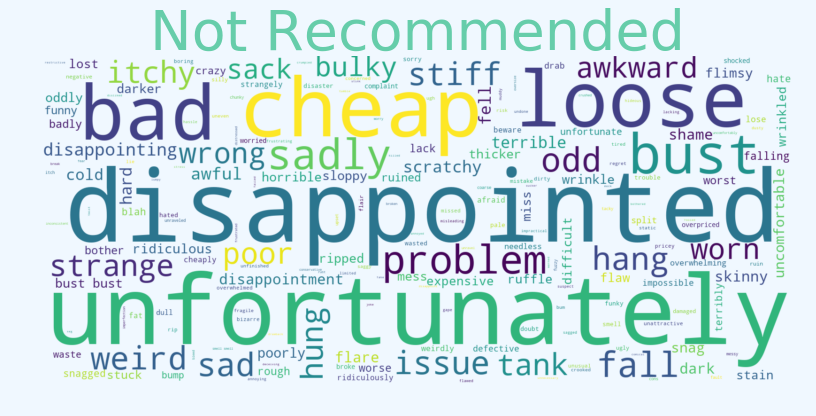

In [64]:
title = 'Not Recommended'
temp = reviews['Review Text'][reviews['Is it Recommended?'] == 0] #All negative recommendations

filtered_list = pos_or_neg(list(temp), keep_positive = False) #keep_positive is false as we want the negative words
plot_wordcloud(text = filtered_list, title = title,stopwords = new_stop)

Based on these the clothing brand could look into making more of their clothes 'comfortable', 'flattering' and 'soft'. And they should focus of improving products that are 'loose', 'cheap', 'itchy', and 'weird' (just to pinpoint a few). It is also interesting to see 'unfortunately' is such a widely used negative word as is almost apologetic and could indicate the customers had high hopes.

## Task 2 - Analysing transportation data

In this task, we started by analysing the cycling trips in Edinburgh in September 2019 provided in cyclingtrips_Sep2019.csv. 
This dataset is kindly supplied for use by Edinburgh Cycle Hire under the Open Government License (OGL) v3.0. 
We have visualised some aspects of the cycle hire data geographically using Folium, and selected some statistics to analyse to gain insight into the usage and uptake of cycle hire in the city. We downloaded the previous 11 months of data available such that we could analyse data for the scheme back to its launch in September 2018.


In [65]:
import sys
!{sys.executable} -m pip install folium

import folium
from folium.plugins import MarkerCluster

We sought first to visualise how busy the stations are as destinations or starting points of cycling trips. 
After dividing the cycling trips into morning and afternoon/evening trips, we show on maps of the city show how many journeys 
end in, or start from, a particular station. 
Journeys are presented on two separate maps, one for start times, and the other for finish times.  For each station ID, circles are plotted 
are plotted to indicate the number of journeys starting/finishing respectively from that location.  The circle radius is proportional
to the number of journeys to enable quick visualisation of their relative use.


You can also separate the stations as destinations or starting points by drawing them on different maps or by colour-coding them.

Just like the first task, this is an open-ended problem. You can address the following or any other interesting questions about bike trips:

- What was the average journey time and distance of bike trips on weekdays? What about weekends?
- What was the most common time(s) of day for journeys to be undertaken?
- Which areas do you suggest for building the new stations based on your analysis?
- Can you visualise which stations were used mostly for shorter trips and which one for longer trips?
- Can you compare the statistics of different months in summer? Is there any remarkable difference between them?

There is more open data available for other cities - here is the link for the data on the similar bike hire scheme in London ([TFL open data](https://cycling.data.tfl.gov.uk)), and for New York [here](https://www.citibikenyc.com/system-data). You could also think about some of the issues involved in other cities and bike share schemes, and perform similar sorts of analyses or comparisons. For example:

- Do bike hire schemes share popular times of day?
- Can you trace the common commute patterns of different cities? Are there any commonalities of shape or structure to the patterns?
- How does the average rental time compare across different cities? How does that time change as the size of the city changes?

In [66]:
#First want to input data:
import pandas as pd
import numpy as np

df = pd.read_csv('cyclingtrips_Sep2019.csv')

The following three cells are initial checks on the cycling_sep_2019 dataframe uploaded, with dtypes identifying the classes of data within each series, and isna().sum() checking for any missing values.  This showed that the data is fairly clean, and no missing rows nor data needed to be removed prior to using the dataframe for analysis.

In [67]:
df.dtypes

started_at                   object 
ended_at                     object 
duration                     int64  
start_station_id             int64  
start_station_name           object 
start_station_description    object 
start_station_latitude       float64
start_station_longitude      float64
end_station_id               int64  
end_station_name             object 
end_station_description      object 
end_station_latitude         float64
end_station_longitude        float64
dtype: object

In [68]:
#We want to change station_start_id and end_station_id to object
df = df.astype({'start_station_id':'object'})
df = df.astype({'end_station_id':'object'})
df.dtypes

started_at                   object 
ended_at                     object 
duration                     int64  
start_station_id             object 
start_station_name           object 
start_station_description    object 
start_station_latitude       float64
start_station_longitude      float64
end_station_id               object 
end_station_name             object 
end_station_description      object 
end_station_latitude         float64
end_station_longitude        float64
dtype: object

In [69]:
#This checks for any missing data
df.isna().sum()

started_at                   0 
ended_at                     0 
duration                     0 
start_station_id             0 
start_station_name           0 
start_station_description    71
start_station_latitude       0 
start_station_longitude      0 
end_station_id               0 
end_station_name             0 
end_station_description      82
end_station_latitude         0 
end_station_longitude        0 
dtype: int64

In [70]:
df.describe().T.drop('count',axis = 1)

,mean,std,min,25%,50%,75%,max
duration,1493.332855,2180.924592,61.000000,573.000000,948.000000,1802.250000,91312.000000
start_station_latitude,55.949423,0.012400,55.923202,55.940238,55.946766,55.957004,55.981286
start_station_longitude,-3.192391,0.024479,-3.300622,-3.205765,-3.191421,-3.182671,-3.073046
end_station_latitude,55.951975,0.014007,55.923202,55.941791,55.950109,55.960944,55.981286
end_station_longitude,-3.190899,0.027161,-3.300622,-3.203184,-3.191346,-3.176686,-3.073046


Here you can see the mean duration in seconds as 1493 seconds. It is also interesting that the midpoint of the start stations and the midpoint of the end stations are roughly the same, which suggests that the same areas are used regardless of when people start and finish 

In [71]:
#This just counts the unique points in our data and gives some more descripition of what we have
df.describe(include = ['O']).T.drop('count',axis = 1)

,unique,top,freq
started_at,13928,2019-09-21 15:18:39.277000+00:00,1
ended_at,13927,2019-09-07 12:06:24.605000+00:00,2
start_station_id,85,259,638
start_station_name,77,St Andrew Square,638
start_station_description,85,North East corner,638
end_station_id,85,257,589
end_station_name,77,Portobello,589
end_station_description,85,Edinburgh Leisure Tumbles Centre,589


In [72]:
#We have imported datetime, as this allows us to convert into a date time format and use this to extract hours from within the dataframe.
from datetime import datetime

#We have that the started_at is as type: pandas.core.series.Series so we needed to convert it to datetime
#We found out how to convert it using an article below on stackflow
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

#Create new columns with just the hour:
#This uses dt.hour to get just the hour from the time date time column. This is a useful feature in date time
df['starting_hour'] = df['started_at'].dt.hour
df['ending_hour']=df['ended_at'].dt.hour

#So this gives us the same table but with two additional columns (starting hour and ending hour)
#This will be useful so we can split the graphs into morning and afternoon/evening trips

#We will also add a weekday column which will give 1 if it is during the week and 0 for weekends
_weekday = np.array([1 if x.weekday() < 5 else 0 for x in df['started_at'] ])
df['weekday'] = _weekday

#Give a sample of this created dataframe
df.sample(10)

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,starting_hour,ending_hour,weekday
5805,2019-09-14 15:19:48.234000+00:00,2019-09-14 16:11:00.096000+00:00,3071,258,Stockbridge,Hamilton Place by Dean Bank Lane,55.958566,-3.208070,357,Macdonald Road,Macdonald Road,55.963995,-3.185189,15,16,0
8050,2019-09-18 21:58:36.058000+00:00,2019-09-18 22:09:00.170000+00:00,624,359,Causewayside,Causewayside outside NLS,55.936430,-3.180115,1024,Meadow Place,End of Meadow Place,55.940238,-3.194640,21,22,1
1642,2019-09-05 16:11:25.792000+00:00,2019-09-05 16:20:21.587000+00:00,535,345,Colinton Road,Colinton Road next to Napier University,55.933398,-3.212429,1024,Meadow Place,End of Meadow Place,55.940238,-3.194640,16,16,1
11344,2019-09-24 16:13:22.455000+00:00,2019-09-24 16:20:59.226000+00:00,456,171,George Square,"George Square, south side in front of University library",55.943084,-3.188311,249,Fountainbridge,Fountainbridge by Gardner's Crescent,55.943357,-3.209248,16,16,1
742,2019-09-02 18:41:51.458000+00:00,2019-09-02 18:47:18.985000+00:00,327,264,Pollock Halls,Pollock Halls Entrance,55.939963,-3.171586,265,Meadows East,Melville Terrace,55.939809,-3.182739,18,18,1
9525,2019-09-21 11:34:58.473000+00:00,2019-09-21 13:02:44.030000+00:00,5265,366,Dudley Gardens,Corner of Dudley Gardens on Newhaven Road,55.975921,-3.191346,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622,11,13,0
596,2019-09-02 13:41:12.625000+00:00,2019-09-02 13:52:15.062000+00:00,662,1026,Constitution Street,Next to Burns Statue,55.975441,-3.166806,366,Dudley Gardens,Corner of Dudley Gardens on Newhaven Road,55.975921,-3.191346,13,13,1
2972,2019-09-08 11:12:35.989000+00:00,2019-09-08 12:06:43.489000+00:00,3247,250,Victoria Quay,Entrance to Scottish Government Office,55.977617,-3.174126,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622,11,12,0
1076,2019-09-03 20:58:52.234000+00:00,2019-09-03 21:01:52.006000+00:00,179,344,Marchmont Crescent,Corner of Marchmont Crescent & Marchmont Road,55.936397,-3.194252,879,Gladstone Terrace,Corner of Gladstone Terrace & Sciennes ROad,55.938024,-3.184979,20,21,1
8249,2019-09-19 11:05:39.161000+00:00,2019-09-19 11:22:14.219000+00:00,995,1019,Grassmarket,West end of Grassmarket,55.947097,-3.197246,885,Wester Coates Terrace,Corner of Wester Coates Terrace & Roseburn Terrace,55.945609,-3.231716,11,11,1


https://stackoverflow.com/questions/28133018/convert-pandas-series-to-datetime-in-a-dataframe

Then we want to separate the data into morning and afternoon/evening:

To separate into morning and evening we want to classify based on the hours.
To do this we want an if loop (using apply) where we have 'MORNING' if true and 'AFTERNOON/EVENING' if false.
We found out how to do this using the link below:
https://datatofish.com/if-condition-in-pandas-dataframe/

We are calling morning from 4am to 12noon (ie:4:00-11:59) and afternoon/evening from 12noon-4am (ie 12:00-3:59)   

In [73]:
df['start_time_of_day'] = df['starting_hour'].apply(lambda x: 'Morning' if (x >=4) & (x<=11) else 'Evening')
df['end_time_of_day'] = df['ending_hour'].apply(lambda x: 'Morning' if (x >=4) & (x<=11) else 'Evening')
df

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,starting_hour,ending_hour,weekday,start_time_of_day,end_time_of_day
0,2019-09-01 00:02:24.545000+00:00,2019-09-01 00:18:32.932000+00:00,968,1039,Lothian Road,Outside the Usher Hall,55.947409,-3.205765,366,Dudley Gardens,Corner of Dudley Gardens on Newhaven Road,55.975921,-3.191346,0,0,0,Evening,Evening
1,2019-09-01 00:07:16.267000+00:00,2019-09-01 00:48:31.838000+00:00,2475,1028,The Tron,Next to Tron Kirk Royal Mile,55.950037,-3.187822,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622,0,0,0,Evening,Evening
2,2019-09-01 00:15:44.914000+00:00,2019-09-01 00:38:15.454000+00:00,1350,290,Bruntsfield links,Corner of Bruntsfield Terrace and Bruntsfield Place,55.937159,-3.206435,346,Morningside Road,Corner of Morningside Road & Morningside Park by M & S car park,55.927986,-3.209739,0,0,0,Evening,Evening
3,2019-09-01 00:27:39.308000+00:00,2019-09-01 00:43:45.157000+00:00,965,1028,The Tron,Next to Tron Kirk Royal Mile,55.950037,-3.187822,1025,Dundee Terrace,Corner of Dundee Street & Dundee Terrace,55.939710,-3.220589,0,0,0,Evening,Evening
4,2019-09-01 00:32:17.434000+00:00,2019-09-01 01:45:50.968000+00:00,4413,870,Hillside Crescent,East corner of Hillside Crescent & London Road,55.957793,-3.175799,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622,0,1,0,Evening,Evening
5,2019-09-01 00:32:31.968000+00:00,2019-09-01 01:36:26.161000+00:00,3834,870,Hillside Crescent,East corner of Hillside Crescent & London Road,55.957793,-3.175799,862,Cramond Foreshore,Cramond foreshore by turning circle,55.980024,-3.300622,0,1,0,Evening,Evening
6,2019-09-01 00:34:35.878000+00:00,2019-09-01 01:08:18.143000+00:00,2022,345,Colinton Road,Colinton Road next to Napier University,55.933398,-3.212429,889,Murrayfield Tram,By the side of the station entrance,55.941956,-3.237802,0,1,0,Evening,Evening
7,2019-09-01 00:35:32.144000+00:00,2019-09-01 01:08:29.093000+00:00,1976,345,Colinton Road,Colinton Road next to Napier University,55.933398,-3.212429,889,Murrayfield Tram,By the side of the station entrance,55.941956,-3.237802,0,1,0,Evening,Evening
8,2019-09-01 00:35:42.620000+00:00,2019-09-01 00:48:54.781000+00:00,792,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,250,Victoria Quay,Entrance to Scottish Government Office,55.977617,-3.174126,0,0,0,Evening,Evening
9,2019-09-01 01:17:37.508000+00:00,2019-09-01 01:44:14.467000+00:00,1596,1028,The Tron,Next to Tron Kirk Royal Mile,55.950037,-3.187822,258,Stockbridge,Hamilton Place by Dean Bank Lane,55.958566,-3.208070,1,1,0,Evening,Evening


Some other links we used to work out how to do unique, count, and work with aggregating data are:

https://www.geeksforgeeks.org/get-unique-values-from-a-column-in-pandas-dataframe/

https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

Then to work out how to use .loc and .iloc (used below) we used : 

https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-pandas-dataframe/36685531

In [74]:
df1 = df.groupby(['start_station_id','start_station_name','start_station_latitude','start_station_longitude'])['duration'].agg(['sum']).reset_index()
df1.columns = ['station_id','station_name','lat','lon','duration']

Firstly, we are going to find where all the stations are situated, for this we got inspiration from https://github.com/python-visualization/folium/blob/master/examples/MarkerCluster.ipynb

In [75]:
#Here we are going to create a map using MarkerCluster map, which will allow us to see where all the stations are situated
from folium.plugins import MarkerCluster

location_map = folium.Map(
    location=[55.924550, -3.176920],
    zoom_start=12,
    titles = "Edinburgh Cycling Map"
)

cap = df1['duration']
lat = df1['lat']
lon = df1['lon']
name = df1['station_name']

#This defines our cluster size, to be used when changing colours 
max_cap, min_cap = max(cap), min(cap)
cluster_size = np.floor((max_cap - min_cap) / 4)


def color_change(c):
    '''
    Function that changes the colour of the cluster when you zoom in on the map
    '''
    if(c < cluster_size):
        return('red')
    elif(cluster_size <= c < 2*cluster_size):
        return('orange')
    elif(2*cluster_size <= c < 2*cluster_size):
        return('yellow')
    else:
        return('green')
    
lat_arr = np.array(lat.tolist())
lon_arr = np.array(lon.tolist())

lat_lon_pair = list(zip(lat_arr, lon_arr))
marker_cluster = MarkerCluster(locations=lat_lon_pair).add_to(location_map)
# Plot markers
for _lat, _lon, _cap, _name in zip(lat, lon, cap, name):
    folium.CircleMarker(location = [_lat, _lon], 
                        radius = 9, 
                        popup = "("+str(_cap)+") "+_name, 
                        fill= True,
                        fill_color = color_change(_cap), 
                        color = "gray", 
                        fill_opacity = 0.9).add_to(marker_cluster)
 
location_map

In [76]:
#CREATE START TIME MAP:

StartTimeMap = folium.Map(
    location = [55.924550, -3.176920],
    zoom_start = 15
)

#Need to have i in unique end_station_name, as otherwise it will repeat for every value, which we don't want
for i in df.end_station_name.unique():
    
    #First we create CircleMarkers to show the proporiton of rides that start from a place (i) in the morning
    folium.CircleMarker(
        
        #This uses .loc to look for series of start station that satisfies the same condition that startname=i, then .iloc to get this first element
        location=[df.loc[df['start_station_name'] == i,'start_station_latitude'].iloc[0], 
                  df.loc[df['start_station_name'] == i,'start_station_longitude'].iloc[0]],
        
        #This command looks for both if the start station is i and that it is in the morning, and if so it will count the amount of times it occcurs
        #We then have chosen to divide by 5 so that the circles don't take over the map, but it still keeps the circles proportionate 
        radius= int(df[(df['start_station_name'] == i)
                                     &(df['start_time_of_day'] == 'Morning')]['start_time_of_day'].count())/5,
        
        color='cyan',
        fill_color='cyan',
    ).add_to(StartTimeMap)

    #Similarly, we create CircleMarkers to show the proporiton of rides that start from a place (i) in the afternoon
    folium.CircleMarker(
        location=[df.loc[df['start_station_name'] == i,'start_station_latitude'].iloc[0], 
                  df.loc[df['start_station_name'] == i,'start_station_longitude'].iloc[0]],
        radius= int(df[(df['start_station_name'] == i)
                                     &(df['start_time_of_day'] == 'Evening')]['start_time_of_day'].count())/5,
        color='magenta',
        fill_color='magenta',
    
    ).add_to(StartTimeMap)
    
    #Add a marker so it is easier to see the pin point of location
    folium.Marker(
        [df.loc[df['start_station_name'] == i,'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == i,'start_station_longitude'].iloc[0]],
        #Adds a popup of the location and amount in that location, when you click on marker
        popup="Place is: " + i + "\nMorning: " + 
        str((df[(df['start_station_name'] == i)&(df['start_time_of_day'] == 'Morning')]['start_time_of_day'].count())) + "\nAfternoon and Evening: " + str((df[(df['start_station_name'] == i)&(df['start_time_of_day'] == 'Evening')]['start_time_of_day'].count())),
    ).add_to(StartTimeMap)
    
StartTimeMap

This map represents the number of journeys starting at each location, seperated by morning and afternoon. The pink circle radius represents the number of journeys starting from the location in the afternoon/evening and the blue represents the morning. We have also included a marker for each location which gives the counts. NOTE: we have scaled the radius by 5 so that the map is clearer to look at.
Just by looking at the map we can see that a lot more journeys start in the afternoon/evening than in the morning with the exception of Pleasance, HSBC UK Lets Ride, Morningside and Causewayside for example.   
This does also make sense as the way we defined afternoon/evening means that this has a wider range of hours.  
   
To delve into the map deeper, we have listed the top 5 starting stations for both the afternoon/evening as listed below:

In [77]:
df.groupby(['start_time_of_day','start_station_name']).size().reset_index(name='Total').sort_values('Total',ascending=False).groupby('start_time_of_day').head(5)

,start_time_of_day,start_station_name,Total
1,Evening,Bristo Square,467
64,Evening,St Andrew Square,458
5,Evening,Castle Street,381
57,Evening,Portobello,337
46,Evening,Meadows East,298
123,Morning,Meadows East,203
140,Morning,St Andrew Square,180
97,Morning,Dundee Terrace,163
131,Morning,Pollock Halls,163
80,Morning,Bruntsfield links,130


The most popular morning stations is quite interesting, as it includes Pollock Halls, Bruntsfield Links and Meadow East (which are all places that students typically live). This suggests that students may be frequent users of the scheme. This also links with the fact that Bristo Square is the most used station in the evening. So we can suggest from this that students may often use these bikes to travel to and from campus. We also note that St Andrews Square is in the central business district where many people may commute, with a lot of journeys starting from here.  Particularly in this location, cycle hire is local to Waverley Train Station, the bus station, and the Edinburgh Tram route.  Use of the cycle hire scheme in this location is positive with regard to it competing with other forms of public transport.

We are now going to create a map of the journey end locations for both the morning and afternoon/evening:

In [78]:
#CREATE END TIME MAP:
#This is done the same as above

EndTimeMap = folium.Map(
    location=[55.924550, -3.176920],
    zoom_start=15
)

for i in df.end_station_name.unique():
    folium.CircleMarker(
        location=[df.loc[df['end_station_name'] == i,'end_station_latitude'].iloc[0], 
                  df.loc[df['end_station_name'] == i,'end_station_longitude'].iloc[0]],
        radius= int(df[(df['end_station_name'] == i)
                                     &(df['end_time_of_day'] == 'Morning')]['end_time_of_day'].count())/5,
        color='orange',
        fill_color='orange',
    ).add_to(EndTimeMap)

    folium.CircleMarker(
        location=[df.loc[df['end_station_name'] == i,'end_station_latitude'].iloc[0], 
                  df.loc[df['end_station_name'] == i,'end_station_longitude'].iloc[0]],
        radius= int(df[(df['end_station_name'] == i)
                                     &(df['end_time_of_day'] == 'Evening')]['end_time_of_day'].count())/5,
        color='purple',
        fill_color='purple',
        #Adds a popup of the location and amount in that location, when you click on circle
    ).add_to(EndTimeMap)
    
    folium.Marker(
        [df.loc[df['end_station_name'] == i,'end_station_latitude'].iloc[0], 
         df.loc[df['end_station_name'] == i,'end_station_longitude'].iloc[0]],
        #Adds a popup of the location and amount in that location, when you click on marker
        popup="Place is: " + i + "\nMorning: " + str((df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Morning')]['end_time_of_day'].count())) + "\nAfternoon and Evening: " + str((df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Evening')]['end_time_of_day'].count())),
    ).add_to(EndTimeMap)
    
EndTimeMap

The following map represents the number of journeys ending at each location, separated by morning and afternoon. The purple circle radius represents the number of journeys starting from the location in the afternoon/evening and the orange represents the morning. We have also included a marker for each location which gives the counts. 
The circle radii are proportional to the number of journeys, and we have scaled the radius by 5 to reduce overlap and increase visibility of station locations particularly in high density areas.  

We can see that a lot more journeys end in the afternoon/evening than in the morning. However, interestingly a lot less journeys end in the evening around Kings Buildings. This would make sense as Kings Buildings is not open in the evening, and student/university staff journeys would likely end there more in the morning.   

As we did when considering start times, to delve deeper into the map, we have listed the top 5 starting stations for both the afternoon/evening as listed below:

As a general comment regarding current cycle hire stations, they are most densely located in the city centre, with other stations scattered in relatively central suburbs, at university/college campuses, and a few located further out such as at out of town shopping centres (eg. Victoria Quay and Fort Kinnaird) or the beach (Portobello and Cramond).

In [79]:
df.groupby(['end_time_of_day','end_station_name']).size().reset_index(name='Total').sort_values('Total',ascending=False).groupby('end_time_of_day').head(5)

,end_time_of_day,end_station_name,Total
57,Evening,Portobello,499
12,Evening,Constitution Street,401
18,Evening,Dudley Gardens,398
4,Evening,Canonmills,397
41,Evening,Leith Walk,392
78,Morning,Bristo Square,161
146,Morning,Victoria Quay,158
114,Morning,Kings Building 3,140
113,Morning,Kings Building 2,131
105,Morning,George Square,129


Looking at the morning data, four of the five most used end stations are university locations. This makes sense with our inference from the starting locations, as in the morning students commute from student housing areas to campus facilities. We also have a lot of journeys that end at Victoria Quay in the morning, which is near a 
shopping centre (Ocean Terminal), which also makes sense as this would open in the morning.  
In the afternoon/evening however, the highest number of journeys end at Leith Walk, Canonmills and Constitution Street (all of which are around Leith) which is away from the city centre.
This could potentially be people going home in the evening, as these seem like more residential areas.
It is also interesting that Portobello has come up as both a popular start and end location, potentially because it is a more remote location. We look further into usage of hire cycles in Portobello in the rest of our analysis. 

#### What was the average journey time and distance of bike trips on weekdays? What about weekends?

We next looked to determine the average journey times and distances for weekdays and weekends.  
While journey times can be determined from durations included in the dataframe, distances were calculated from the latitude and longitudes of the start and end stations.

Distances are calculated 'as the crow flies'.  There is no tracking on hire bikes (appropriately!) that might give more detailed insights of actual journey distances or enable visualising most popular routes in more detail. The council might be interested in such information in relation to where to construct dedicated cycleways to encourage cyclists.
It is however of interest to note that a high number of journeys both start and end at the same station, ie. they are circular with distance = 0.

In [80]:
df['dayweek'] = df['started_at'].dt.weekday  #Returns day of week as integer, Mon = 0 & Sun = 6.
df['distance'] = ""                          #Adds empty col to dataframe

time_wkday_journey=0
n_wkday_journeys=0

time_wkend_journey=0
n_wkend_journeys=0

#C alculation of average weekday journey time
for i in range(len(df['started_at'])):
    if df['dayweek'][i]<5:
        time_wkday_journey += df['duration'][i] #Time in seconds
        n_wkday_journeys +=1
    else:
        time_wkend_journey += df['duration'][i] #Time in seconds
        n_wkend_journeys +=1

avg_wkday_journey = time_wkday_journey/n_wkday_journeys//60
avg_wkend_journey = time_wkend_journey/n_wkend_journeys//60

print("Average journey time on weekdays is: ",avg_wkday_journey)
print("Average journey time on weekends is: ",avg_wkend_journey)

Average journey time on weekdays is:  21.0
Average journey time on weekends is:  31.0


Average journey times on weekdays are 50% shorter than on weekends, suggesting that relatively short commuter journeys dominate during the week, whereas people maybe have more time to venture further at weekends (albeit we do not know how far they cycle, rather just how long the bike was hired).

In [81]:
from math import sin, cos, sqrt, atan2, radians

In [82]:
def get_distance(lat1, lon1, lat2, lon2):
    '''
    This function calculates the distance 'as the crow flies' between the start and end stations based on their latitude and longitude.

    '''
    # approximate radius of earth in km
    R = 6373.0
    print(lat1.shape)
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(lat2), np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = np.round(R * c,3)
    return distance

def generate_distance_col(df):
    '''
    This function populates the 'distance' column in the dataframe with the value calculated for that journey using the get_distance(lat1,lon1,lat2,lon2) function.
    '''
    lat1, lon1 = np.array(df['start_station_latitude']), np.array(df['start_station_longitude'])
    lat2, lon2 = np.array(df['end_station_latitude']), np.array(df['end_station_longitude'])
    return get_distance(lat1, lon1, lat2, lon2)

In [83]:
#Populate the distance column given the function we created
df['distance'] = generate_distance_col(df)

(13928,)


In [84]:
df['distance'].mean()
df.groupby([df.weekday])['distance'].mean()

weekday
0    1.892841
1    1.829003
Name: distance, dtype: float64

Average journey distances do not seem to differ between weekdays and weekends, ( where weekday is 0 and weekend is 1) however we note that actual distance is not known.  This metric is not particularly telling as it only reflects the distance between the start and end stations, and is independent of the actual journey distance.  

/home/kevin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


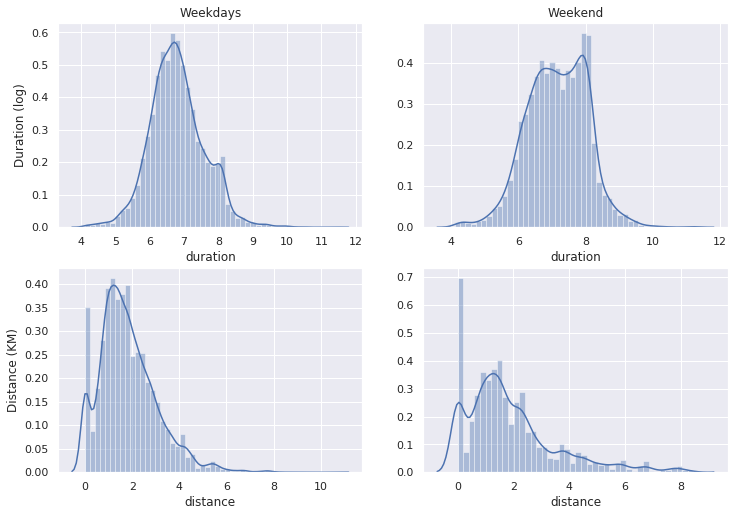

In [85]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
sns.distplot(np.log(df[df['weekday'] == 1]['duration']), ax=ax[0,0])
sns.distplot(np.log(df[df['weekday'] == 0]['duration']), ax=ax[0,1])
ax[0,0].set_ylabel('Duration (log)')
ax[0,0].set_title('Weekdays')
ax[0,1].set_title('Weekend')
sns.distplot(df[df['weekday'] == 1]['distance'], ax=ax[1,0])
sns.distplot(df[df['weekday'] == 0]['distance'], ax=ax[1,1])
ax[1,0].set_ylabel('Distance (KM)')
plt.show()

#### What was the most common time(s) of day for journeys to be undertaken?

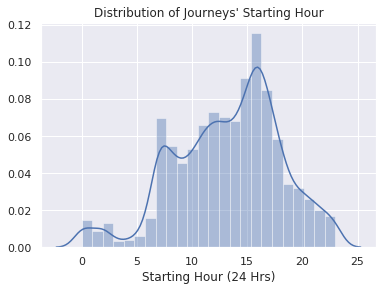

In [86]:
# Plot a histogram of the data
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(df['starting_hour'],bins=24, ax=ax)
ax.set_title("Distribution of Journeys' Starting Hour")
ax.set_xlabel("Starting Hour (24 Hrs)")
plt.show()


As can be seen from the histogram (of the Sep 2019 data) the most common time of day for journeys to be taken is at 15:00 and the least common is from 0300-0400.

In [87]:
def timeslice(x):
    """function to slice time into 20 minutes intervals"""
    return (x.hour * 3 + np.floor(x.minute/20)).astype(int)
df['started_at_timeslice'] = df['started_at'].apply(timeslice)

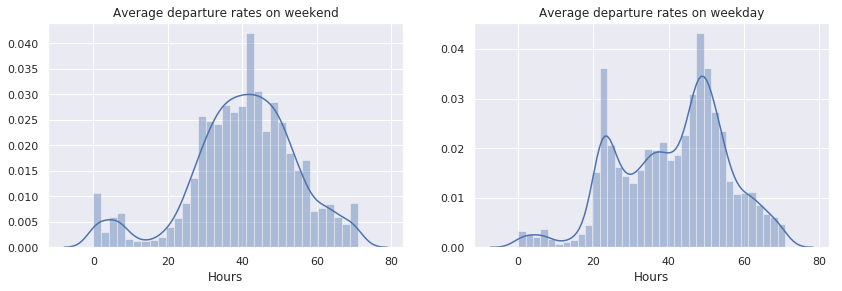

In [88]:
f, axes = plt.subplots(1,2, figsize=(14,4), sharex=False)
title = ['weekend','weekday']
for i,x in enumerate([0,1]):
    sns.distplot(df[df['weekday'] == x]['started_at_timeslice'], ax=axes[i])
    axes[i].set_title("Average departure rates on {}".format(title[i]))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Hours")
plt.show()

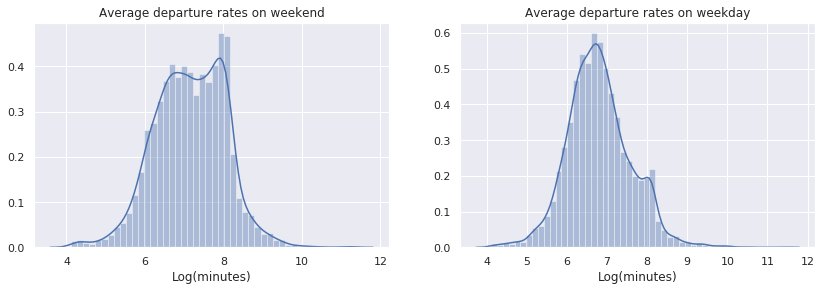

In [89]:
f, axes = plt.subplots(1,2, figsize=(14,4), sharex=False)
title = ['weekend','weekday']
for i,x in enumerate([0,1]):
    sns.distplot(np.log(df[df['weekday'] == x]['duration']), ax=axes[i])
    axes[i].set_title("Average departure rates on {}".format(title[i]))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Log(minutes)")
plt.show()

#### Can you visualise which stations were used mostly for shorter trips and which one for longer trips?

We created a smaller dataframe for the purpose of analysing the top 5 short journeys, in morning and afternoon/evening.

In [90]:
df1 = df.groupby(['start_station_id','start_station_name','start_station_latitude','start_station_longitude', 'start_time_of_day'])['duration'].agg(['sum']).reset_index()
df1.columns = ['station_id','station_name','lat','lon','start_time_of_day','duration']

In [91]:
morning = df1[df1['start_time_of_day'] == 'Morning']
morning.sort_values('duration', ascending = False).head(5)

,station_id,station_name,lat,lon,start_time_of_day,duration
29,257,Portobello,55.957004,-3.116888,Morning,235486
43,265,Meadows East,55.939809,-3.182739,Morning,202560
41,264,Pollock Halls,55.939963,-3.171586,Morning,198596
120,1025,Dundee Terrace,55.939710,-3.220589,Morning,193760
33,259,St Andrew Square,55.954906,-3.192444,Morning,182418


In [92]:
afternoonevening = df1[df1['start_time_of_day'] == 'Evening']
afternoonevening.sort_values('duration', ascending = False).head(5)

,station_id,station_name,lat,lon,start_time_of_day,duration
28,257,Portobello,55.957004,-3.116888,Evening,978757
32,259,St Andrew Square,55.954906,-3.192444,Evening,586830
46,289,Castle Street,55.951501,-3.203184,Evening,508655
44,285,Ocean Terminal,55.981286,-3.176351,Evening,492167
12,248,Bristo Square,55.945834,-3.189053,Evening,488620


From these statistics, we can see that Portobello has the highest durations for journeys starting from its station. This may suggest that the most money can be made from here, as longer durations yield a higher return.  In this instance we can surmise that distances are also relatively long due to Portobello being a beach suburb further from the higher density hire stations in the city centre.
While long journeys yield higher revenue per journey, hire rates typically are less for durations beyond the first half hour.  The rate structure is presumably based on a large proportion of journeys being very short.  This can be seen in a histogram of the journey times for journeys less than 2hours below.

In [93]:
int(df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Evening')]['duration'].sum())

0

In [94]:
#DURATION MAP:
#This is done the same as above

#DURATION MAP:
#This is done the same as above

Duration = folium.Map(
    location=[55.924550, -3.176920],
    zoom_start=15
)

by_avg_duration = (df.groupby(['start_station_id', 'duration'], as_index=False).mean()
            .groupby('start_station_id')['duration'].mean())
max_duration = max(by_avg_duration)
min_duration = min(by_avg_duration)
diff = np.floor(max_duration - min_duration)

def normalise_ratio(d, max_ratio = 200):
    '''
    Function that will normalise the ratio depending on the mean
    '''
    r = ((d-min_duration) / diff) * max_ratio
    return r

def set_color(d):
    '''
    Function that sets one colour if in the morning one if in the evening
    '''
    if d == 'Evening':
        return 'Red'
    else:
        return 'Blue'

for i in df.end_station_name.unique():
    folium.CircleMarker(
         location=[df.loc[df['end_station_name'] == i,'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == i,'end_station_longitude'].iloc[0]],
         radius=normalise_ratio(int(df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Evening')]['duration'].mean())),
         color= 'green',
         fill_color='green'
    ).add_to(Duration)
    
    folium.CircleMarker(
         location=[df.loc[df['end_station_name'] == i,'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == i,'end_station_longitude'].iloc[0]],
         radius=normalise_ratio(int(df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Morning')]['duration'].mean())),
         color= 'blue',
         fill_color='blue'
    ).add_to(Duration)
    
    folium.Marker(
        [df.loc[df['end_station_name'] == i,'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == i,'end_station_longitude'].iloc[0]],
        #Adds a popup of the location and amount in that location, when you click on marker
        popup="Place is: " + i + "\nMorning: " + str((df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Morning')]['duration'].mean())) + "\nAfternoon and Evening: " + str((df[(df['end_station_name'] == i)&(df['end_time_of_day'] == 'Evening')]['duration'].mean())),
    ).add_to(Duration)
        
Duration

From the above map you can see the average duration from each station. Clearly, places where there are outskirts of the city have large avarage duration which is expected since it takes further to travel from there.

#### Which areas do you suggest for building the new stations based on your analysis?

For this question we created two functions to visualise more on the maps. To do this we got inspiration from: https://imrankhan17.github.io/pages/Analysing%20tube%20journeys%20with%20Folium.html
We firstly are going to use plot_routes to test for the first n routes.
We are also going to use the function stations_network_start, which will allow us to put in a location and all the routes that come from this.
We also have created the function stations_network start to see all the routes that go to a particular station. 
We will then use these functions to figure out more from the data, to decide where to build new stations.

In [95]:
def plot_routes(n):
    '''
    Function plots the n most common routes
    '''
    k = folium.Map(location=[55.924550, -3.176920],zoom_start=15)
    routes = df.groupby(['start_station_name','end_station_name']).size().sort_values(ascending=False).head(n)
    
    for i in routes.iteritems():
        folium.PolyLine([[df.loc[df['start_station_name'] == (i[0])[0],'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == (i[0])[0],'start_station_longitude'].iloc[0]], [df.loc[df['end_station_name'] == (i[0])[1],'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == (i[0])[1],'end_station_longitude'].iloc[0]]],
                        popup= format(i[0][0]) + "to" + format(i[0][1]) + "with" + format(i[1]) + "journeys",
                        opacity=1,
                        color="black"
        ).add_to(k)
        
        folium.Marker(
            [df.loc[df['start_station_name'] == (i[0])[0],'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == (i[0])[0],'start_station_longitude'].iloc[0]],
            #Adds a popup of the location and amount in that location, when you click on marker
            popup= format(i[0][0]) + " to  " + format(i[0][1]) + " with " + format(i[1]) + " journeys"
        ).add_to(k)
        
    return k

In [96]:
def station_network_start(s):
    '''
    Returns a map of all the destination stations departing from 's'
    Thickness of lines is a function of the frequency of the journeys.
    Average journey time obtained from clicking on relevant line
    '''
    
    #Create a dataframe that only includes when the start station name is s
    start_station=df[df['start_station_name'] == s]
    #If there are no journeys from a station we want it to return that there are no journeys
    if len(start_station)==0:
        return 'No journeys from this station'
    n= folium.Map(
        location=[df.loc[df['start_station_name'] == s,'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == s,'start_station_longitude'].iloc[0]],
        zoom_start=13)
    folium.Marker(location=[df.loc[df['start_station_name'] == s,'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == s,'start_station_longitude'].iloc[0]],
                  #Give the name of the location
                  popup = start_station.start_station_name.iloc[0],
                  icon=folium.Icon(color='red')).add_to(n)
    
    #Get all the end stations that end with this as the start:
    end_stations = start_station.groupby('end_station_name').agg({'end_station_name':'count',
                                                                 'duration':'mean'})
    for i in end_stations.itertuples():
        folium.PolyLine([[df.loc[df['start_station_name'] == s,'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == s,'start_station_longitude'].iloc[0]], [df.loc[df['end_station_name'] == (i[0]),'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == (i[0]),'end_station_longitude'].iloc[0]]],
                        color='blue').add_to(n)
    return(n)

In [97]:
def station_network_end(s):
    '''
    Returns a map of all the destination stations departing from 's'
    Thickness of lines is a function of the frequency of the journeys.
    Average journey time obtained from clicking on relevant line
    '''
    
    #Create a dataframe that only includes when the start station name is s
    end_station=df[df['end_station_name'] == s]
    #If there are no journeys from a station we want it to return that there are no journeys
    if len(end_station)==0:
        return 'No journeys to this station'
    n= folium.Map(
        location=[df.loc[df['end_station_name'] == s,'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == s,'end_station_longitude'].iloc[0]],
        zoom_start=13)
    folium.Marker(location=[df.loc[df['end_station_name'] == s,'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == s,'end_station_longitude'].iloc[0]],
                  #Give the name of the location
                  popup = end_station.end_station_name.iloc[0],
                  icon=folium.Icon(color='red')).add_to(n)
    
    #Get all the end stations that end with this as the start:
    start_stations = end_station.groupby('start_station_name').agg({'start_station_name':'count',
                                                                 'duration':'mean'})
    for i in start_stations.itertuples():
        folium.PolyLine([[df.loc[df['end_station_name'] == s,'end_station_latitude'].iloc[0], df.loc[df['end_station_name'] == s,'end_station_longitude'].iloc[0]], [df.loc[df['start_station_name'] == (i[0]),'start_station_latitude'].iloc[0], df.loc[df['start_station_name'] == (i[0]),'start_station_longitude'].iloc[0]]],
                        color='purple').add_to(n)
    return(n)

First of all I am going to plot the first n=10 routes:

In [98]:
plot_routes(10)

As can be seen, even though we are plotting n=10 only 6 clear routes can be seen, which means we must have some routes going to and from itself, or we have similar routes. We can check this by looking at the data:

In [99]:
df.groupby(['start_station_name','end_station_name']).size().reset_index(name='Total').sort_values('Total',ascending=False).head(10)

,start_station_name,end_station_name,Total
2040,Portobello,Portobello,173
173,Canonmills,Canonmills,76
180,Canonmills,Dudley Gardens,73
2018,Portobello,Constitution Street,59
556,Constitution Street,Portobello,58
2246,St Andrew Square,Dudley Gardens,54
2240,St Andrew Square,Constitution Street,50
1977,Pollock Halls,George Square,45
2260,St Andrew Square,Leith Walk,45
2234,St Andrew Square,Canonmills,44


From this we can see that we have some very popular stations - especially Portobello. This station has come up previously in our analysis, with it being one of the most used stations. Insterestingly, Canonmills, St Andrew Square have also been seen as well used. This suggests that we have a lot of demand for bikes in these areas. 
We can then look more into this data with the station_network start and end

In [100]:
station_network_start('Portobello')

In [101]:
station_network_end('Portobello')

The graphs look very similar, but with slightly more routes going into Portobello than out. 

Howevever as we have seen earlier, Portobello is quite a remote, yet popular location. Therefore JustEat could either consider putting more cycles around the Portobello area. As it has one of the biggest demand/use. Similarly, when looking at the total durations to and from each location we can see that Portobello has the largest radius. Therefore the journeys there take the longest, and therefore make the most money! Therefore it may be in JustEats intrest to build more stations around Portobello as this is where lots of people take bikes to.

However it also has to be said that, since the first hour is most expensive on just eat cycles, then hire rates are lower for subsequent hours, more money would also be made by more and shorter journeys, therefore they could also consider stations where the duration is shortest. From this ##ADDDd

#### Plot over month

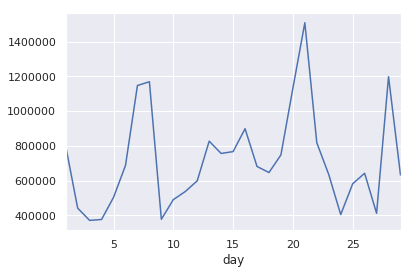

In [102]:
df["day"]=df["started_at"].dt.day
g = df.groupby([df.day])['day'].count()
%matplotlib inline
df.groupby([df.day])['duration'].sum().plot(kind='line')

This plot shows that bike usage massively varies over one month. We can expect this due to weather issues etc.

#### Can you compare the statistics of different months in summer? Is there any remarkable difference between them?

We downloaded the equivalent Edinburgh cycle hire data for the previous 11 months, from which to analyse how usage of the Just Eat cycles has developed and changed since its launch in September 2018.

In [103]:
#Get Yearly Data
Oct2018= pd.read_csv('Oct2018.csv')
Nov2018 = pd.read_csv('Nov2018.csv')
Dec2018 = pd.read_csv('Dec2018.csv')
Jan2019 = pd.read_csv('Jan2019.csv')
Feb2019 = pd.read_csv('Feb2019.csv')
Mar2019 = pd.read_csv('Mar2019.csv')
Apr2019 = pd.read_csv('Apr2019.csv')
May2019 = pd.read_csv('May2019.csv')
Jun2019 = pd.read_csv('Jun2019.csv')
Jul2019= pd.read_csv('July2019.csv')
Aug2019 = pd.read_csv('Aug2019.csv')
Sep2019 = pd.read_csv('Sep2019.csv')

#Put the data together, using concat
Year = [Oct2018, Nov2018, Dec2018, Jan2019, Feb2019, Mar2019, Apr2019, May2019, Jun2019, Jul2019, Aug2019, Sep2019]
Year = pd.concat(Year)


FileNotFoundError: [Errno 2] File b'Jun2019.csv' does not exist: b'Jun2019.csv'

In [ ]:
Year["started_at"] = pd.to_datetime(Year["started_at"])
Year["ended_at"] = pd.to_datetime(Year["ended_at"])
Year["day"]=Year["started_at"].dt.day
Year["month"]=Year["started_at"].dt.month
Year["year"]=Year["started_at"].dt.year

import matplotlib.pyplot as plt

Count= Year.groupby(["year","month","day"])['duration'].sum()
Year = Year.sort_values('started_at', ascending=True)

Count.plot(figsize=(12,5))

As you can see the highest peak is around May, which is typically a month of nice spring weather in Scotland, particularly last year when Edinburgh experienced a really nice spell (https://www.timeanddate.com/weather/uk/edinburgh/historic?month=5&year=2018). This would make sense in relation to the peak journeys, as people are more likely to get outside, and cycle, when the weather is nice!

## Comparison with London's hire bike scheme

London established a public bicycle scheme in 2010, often referred to as Boris bikes after Boris Johnson, the incumbent mayor when the scheme was launched.  We obtained equivalent data and coincident data for London's scheme against which to compare usage with Edinburgh.
London's data was presented in slightly different series such that we needed to create a dataframe from it to enable comparison with our Edinburgh dataframe.

We have generated equivalent statistics for journey time and distances on weekdays and weekends for comparison.


In [ ]:
df_lon = pd.read_csv('journeys.csv')

In [ ]:
df_lon.dtypes

In [ ]:
df_lon.isna().sum()

In [ ]:
df_lon.describe().T.drop("count", axis=1)

In [ ]:
import datetime as dt
s_date = df_lon['Start Date'].values
s_month = df_lon['Start Month'].values
s_year = df_lon['Start Year'].values
s_hour = df_lon['Start Hour'].values
s_minute = df_lon['Start Minute'].values

weekday = np.zeros(len(s_date))
cnt = 0
for _year, _month, _date, _hour, _minute in zip(s_year, s_month, s_date, s_hour, s_minute):
    _dt = dt.datetime(_year, _month, _date, _hour, _minute)
    _weekday = _dt.weekday()
    weekday[cnt] = _weekday
    cnt += 1

is_weekday = weekday < 5
df_lon['weekday'] = is_weekday
df_lon['dayweek'] = weekday

df_lon['Start Timeslice'] = (s_hour*3 + np.floor(s_minute/20)).astype(int)

We removed extreme values from the London data in relation to journey durations.  There had been some anomalies in Edinburgh's September data such as one duration approximately 25 hours.  In that case it would appear the bike was maybe not checked back in (via the app) for the charges to stop.

In [ ]:
# Look for outliers
# We need to remove outlier
sns.boxplot(x=df_lon['Journey Duration']).set_title('Box plot of Journey Duration')

In [ ]:
q4 = df_lon['Journey Duration'].quantile(0.99)
q1 = df_lon['Journey Duration'].quantile(0.01)
df_lon = df_lon[(df_lon['Journey Duration'] < q4) & (df_lon['Journey Duration'] > q1)]

In [ ]:
sns.boxplot(x=df_lon['Journey Duration'])

Below we have generated equivalent charts for London weekday and weekend journey durations.

In [ ]:
f, axes = plt.subplots(1,2, figsize=(14,4), sharex=False)
title = ['weekend','weekday']
for i,x in enumerate([0,1]):
    sns.distplot(df[df['weekday'] == x]['started_at_timeslice'], ax=axes[i], label='Edinburgh',color="b")
    sns.distplot(df_lon[df_lon['weekday'] == x]['Start Timeslice'], ax=axes[i], label='London', color="r")
    axes[i].set_title("Average departure rates on {}".format(title[i]))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Hours (bins = 20min)")
axes[0].legend()
axes[1].legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(np.log(df[df['weekday'] == 1]['duration']), ax=ax[0], label='Edinburgh')
sns.distplot(np.log(df_lon[df_lon['weekday'] == 1]['Journey Duration']), ax=ax[0], label='London',color="r")

sns.distplot(np.log(df[df['weekday'] == 0]['duration']), ax=ax[1], label='Edinburgh')
sns.distplot(np.log(df_lon[df_lon['weekday'] == 0]['Journey Duration']), ax=ax[1], label='London',color="r")
ax[0].set_ylabel('Duration (log)')

ax[0].set_title('Weekdays')
ax[1].set_title('Weekend')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
df.groupby([df.dayweek])['duration'].mean().plot(kind='line', ax=ax, label='Edinburgh')
ax.set_ylabel('Duration')
ax.set_title('Average of Trip Duration on Each Day of Week')
df.groupby([df_lon.dayweek])['duration'].mean().plot(kind='line', ax=ax, label='London')
ax.legend(loc='best')
ax.set_xticklabels( ['Mon','Tue','Wed','Thur','Fri','Sat','Sun'], fontsize=12)

From the average trip durations, we can see that Edinburgh hire cycles appear to be used more for leisure during the weekend than in London.  Noting that the London scheme is significantly larger and more extablished, it is possible that London cycle hirers do do some longer journeys at weekends, however that the average is pulled down by the volume of short journeys.